# Quality check on fluorescence data 

#### Fluorescence data from WETLabs sensor
Chlorophyll-a fluorescence is computed from the raw counts given as an ouput from the sensor as fluorescence=SF*fluorescence counts-DC, where DC is the dark count and SF is the scaling factor. When purchased, the sensor is calibrated from the manifacturer and specific DC and SF are given. This calibration values are given in the metadat for each of the datasets founf in ERDDAP. The DC and Sf can vary from the manifacturer calibration for multiple reasons, this is why we try to find a more suitble DC and apply a recalibration to all the datasets.
In order to get a more accurate DC, we assumed no fluorescence signal in deeper waters and used the deep fluorescence median as DC.

In [2]:
import utils
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import style
from statistics import median
import gsw
import ast
plt.rcParams.update({'font.size': 16})
style.use('presentation.mplstyle')

In [3]:
### Import datasts fform ERDDAP

In [4]:
e = utils.init_erddap()

# Fetch dataset list
e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas(parse_dates=['minTime (UTC)', 'maxTime (UTC)'])

print(f"found {len(df_datasets)} datasets")

found 215 datasets


In [5]:
# drop the allDatasets row and make the datasetID the index for easier reading
df_datasets.set_index("datasetID", inplace=True)
df_datasets.drop("allDatasets", inplace=True)

In [6]:
df_datasets = df_datasets[df_datasets.index.str[:3] == "nrt"] #Select only near real time data
from tqdm import tqdm
ds_meta = {}
for dataset_id in tqdm(df_datasets.index):
    ds_meta[dataset_id] = utils.get_meta(dataset_id)

100%|██████████| 108/108 [00:39<00:00,  2.73it/s]


### Create datasets for each of the 4 SAMBA observatories

* Skagerrak: Triangle transect SAMBA in Skagerrak
* Kattegat: North-South SAMBA transect in Kattegat crossing the front
* Bornholm: SAMBA transect in Bornholm and no Nord Stream transect data are included
* Gotland: CABLE bowtie transect in Gotland 

In [7]:
skagerrak_missions = []
for dataset_id, meta in ds_meta.items():
    if "Skagerrak" in meta["basin"]:
        if 'deployment and recovery in Skagerrak' in meta['comment']:#Do not include kattegat data
            skagerrak_missions.append(dataset_id)
print(f"NRT Missions that contain skagerrak data: {skagerrak_missions}")

NRT Missions that contain skagerrak data: ['nrt_SEA069_M13', 'nrt_SEA055_M26', 'nrt_SEA055_M33', 'nrt_SEA055_M35', 'nrt_SEA045_M33', 'nrt_SEA045_M36', 'nrt_SEA045_M37', 'nrt_SEA045_M41', 'nrt_SEA045_M44', 'nrt_SEA045_M50', 'nrt_SEA045_M51', 'nrt_SEA045_M52', 'nrt_SEA063_M24', 'nrt_SEA044_M25', 'nrt_SEA044_M28', 'nrt_SEA044_M29', 'nrt_SEA044_M32', 'nrt_SEA044_M33', 'nrt_SEA044_M34', 'nrt_SEA044_M35', 'nrt_SEA044_M45', 'nrt_SEA044_M46', 'nrt_SEA066_M16', 'nrt_SEA056_M42', 'nrt_SEA061_M45']


In [8]:
kattegat_missions = []
for dataset_id, meta in ds_meta.items():
    if "Kattegat" in meta["basin"]:
        kattegat_missions.append(dataset_id)
print(f"NRT Missions that contain kattegat data: {kattegat_missions}")

NRT Missions that contain kattegat data: ['nrt_SEA055_M35', 'nrt_SEA055_M39', 'nrt_SEA055_M41', 'nrt_SEA055_M45', 'nrt_SEA055_M46', 'nrt_SEA055_M48', 'nrt_SEA055_M50', 'nrt_SEA055_M52', 'nrt_SEA061_M56', 'nrt_SEA061_M57', 'nrt_SEA061_M60', 'nrt_SEA061_M62', 'nrt_SEA061_M63']


In [9]:
bornholm_missions = []
for dataset_id, meta in ds_meta.items():
    if "Bornholm" in meta["basin"]:
        if 'SAMBA' in meta['deployment_name']: #Do not include Nord stream data
                bornholm_missions.append(dataset_id)
print(f"NRT Missions that contain bornholm data: {bornholm_missions}")


NRT Missions that contain bornholm data: ['nrt_SEA069_M11', 'nrt_SEA055_M16', 'nrt_SEA055_M18', 'nrt_SEA055_M19', 'nrt_SEA055_M20', 'nrt_SEA055_M21', 'nrt_SEA055_M24', 'nrt_SEA055_M28', 'nrt_SEA055_M31', 'nrt_SEA055_M37', 'nrt_SEA055_M43', 'nrt_SEA045_M48', 'nrt_SEA045_M54', 'nrt_SEA045_M56', 'nrt_SEA045_M60', 'nrt_SEA045_M62', 'nrt_SEA045_M64', 'nrt_SEA045_M65', 'nrt_SEA045_M67', 'nrt_SEA045_M69', 'nrt_SEA045_M71', 'nrt_SEA063_M17', 'nrt_SEA063_M18', 'nrt_SEA063_M19', 'nrt_SEA063_M20', 'nrt_SEA063_M21', 'nrt_SEA063_M22', 'nrt_SEA063_M33', 'nrt_SEA063_M35', 'nrt_SEA063_M37', 'nrt_SEA063_M38', 'nrt_SEA063_M39', 'nrt_SEA063_M40', 'nrt_SEA044_M40', 'nrt_SEA044_M48', 'nrt_SEA066_M10', 'nrt_SEA066_M12', 'nrt_SEA066_M14', 'nrt_SEA077_M11', 'nrt_SEA077_M13', 'nrt_SEA077_M15', 'nrt_SEA056_M40', 'nrt_SEA061_M38', 'nrt_SEA061_M39', 'nrt_SEA061_M40', 'nrt_SEA061_M42', 'nrt_SEA061_M43', 'nrt_SEA061_M48', 'nrt_SEA061_M50', 'nrt_SEA061_M54']


In [10]:
gotland_missions = []
for dataset_id, meta in ds_meta.items():
    if "Gotland" in meta["basin"]:
        gotland_missions.append(dataset_id)
print(f"NRT Missions that contain gotland data: {gotland_missions}")

NRT Missions that contain gotland data: ['nrt_SEA068_M27', 'nrt_SEA069_M9', 'nrt_SEA055_M23', 'nrt_SEA067_M26', 'nrt_SEA067_M27', 'nrt_SEA067_M29', 'nrt_SEA067_M30', 'nrt_SEA067_M32', 'nrt_SEA067_M37', 'nrt_SEA066_M41', 'nrt_SEA066_M42', 'nrt_SEA066_M43']


## Download data

In [14]:
datasets_to_download = skagerrak_missions
ds_dictS = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

In [15]:
datasets_to_download = kattegat_missions
ds_dictK = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

In [16]:
datasets_to_download = bornholm_missions
ds_dictB = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

In [17]:
datasets_to_download = gotland_missions
ds_dictG = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

### Create info tables and plots

In [18]:
def calibration_table(missions,dic, mindepth):
    '''
    Parameters
    ----------------
    
    missions:list of the missions 
    dic: datasets for all the missions
    mindepth: min depth which will be considered to 

    #Returns
    ----------------
    inf: Datframe with info for each glider mission at a specific observatory
    
    '''
    #Create pandas dataframe
    
    info=pd.DataFrame(columns = ['Glider','Mission',  'Start_Date','DC_calibration','Min_raw_count', 'SN_sensor', 'Depth_median','DC_calibration>Min_raw_count'])
    info.Mission= range(0,len(missions))
    
    for i in range (len (missions)): 
        d=dic[missions[i]]
        info.Glider[i]=f'SEA0{d.attrs["glider_serial"]}'
        info.Mission[i]=d.attrs["deployment_id"]
        info.Start_Date[i]=d.attrs["deployment_start"]
        info.DC_calibration[i]=ast.literal_eval(d.optics)['calibration_parameters']['Chl_DarkCounts']
        
        #Do not include info for the datsets with weird data. Only include data if we have mena values above 1
        if d.chlorophyll_raw.mean()>1:
            info.Min_raw_count[i]=np.nanmin(d.chlorophyll_raw[d.depth> mindepth])
            info.SN_sensor[i]= ast.literal_eval(d.optics)['serial']
            a=d.depth[d.depth<1000].max()
            lim=np.nanmedian(d.chlorophyll_raw[(d.depth> (a-(a/10)))])
            info.Depth_median[i]= lim
        # Give info about sensor behaviour. It is not a good sign if we have counts below the DC from manifactuerer. So if last column is '0' bas sign
        if info['DC_calibration'][i]>info['Min_raw_count'][i]:
            info['DC_calibration>Min_raw_count'][i]=1
        else:
            info['DC_calibration>Min_raw_count'][i]=0
        #inf=info.sort_values(by=["Start_Date"], ascending=True)
        inf=info.sort_values(by=["SN_sensor"], ascending=True)            
    return inf
    

In [19]:
calibration_table(skagerrak_missions,ds_dictS, 80)

C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Glider[i]=f'SEA0{d.attrs["glider_serial"]}'
C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Mission[i]=d.attrs["deployment_id"]


Glider Mission                     Start_Date DC_calibration  \
13  SEA044      25  2020-08-20T06:03:24.123000000             48   
23  SEA056      42  2021-10-18T07:54:16.762000000             48   
10  SEA045      51  2021-12-03T10:44:35.526000000             48   
4   SEA045      33  2020-08-20T07:47:23.818000000             48   
5   SEA045      36  2021-03-01T08:48:15.108000000             48   
6   SEA045      37  2021-03-19T14:15:45.306000000             48   
7   SEA045      41  2021-04-13T12:04:36.732000000             48   
8   SEA045      44  2021-07-22T08:28:58.686000000             48   
9   SEA045      50  2021-11-14T10:35:45.853000000             48   
11  SEA045      52  2021-12-21T18:39:05.675000000             48   
19  SEA044      35  2021-07-22T08:16:52.026000000             46   
18  SEA044      34  2021-06-18T12:55:43.509000000             46   
17  SEA044      33  2021-05-18T08:15:00.958000000             46   
16  SEA044      32  2021-04-13T11:33:11.595000000             46   
15  SEA044      29  2021-03-19T14:14:45.266000000             46   
21  SEA044      46  2021-12-21T18:39:46.414000000             46   
20  SEA044      45  2021-12-02T14:04:25.689000000             46   
14  SEA044      28  2021-02-22T07:40:46.021000000             46   
3   SEA055      35  2022-03-24T09:39:57.208000000             46   
2   SEA055      33  2022-02-26T10:31:38.737000000             46   
1   SEA055      26  2021-10-18T07:53:00.197000000             46   
12  SEA063      24  2021-09-20T11:45:46.641000000             48   
24  SEA061      45  2021-09-20T11:39:18.572000000             46   
22  SEA066      16  2022-01-15T10:49:53.409000000             48   
0   SEA069      13  2022-10-24T14:39:30.677000000             47   

   Min_raw_count SN_sensor Depth_median  
13          52.0      5948         53.0  
23          50.0      6134         52.0  
10          51.0      6170         53.0  
4           53.0      6170         53.0  
5           55.0      6170         72.0  
6           54.0      6170         59.0  
7           53.0      6170         54.0  
8           52.0      6170         53.0  
9           51.0      6170         53.0  
11          51.0      6170         53.0  
19          33.0      6597         40.0  
18          33.0      6597         40.0  
17          34.0      6597         42.0  
16          37.0      6597         43.0  
15          39.0      6597         49.0  
21          28.0      6597         42.0  
20          28.0      6597         41.0  
14          38.0      6597         50.0  
3           18.0      6598         33.0  
2           19.0      6598         35.0  
1           13.0      6598         27.0  
12          50.0      6661         52.0  
24          16.0      6753         31.0  
22          28.0      6754         39.0  
0           42.0      6756         53.0

In [20]:
calibration_table(kattegat_missions,ds_dictK, 80)

C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Glider[i]=f'SEA0{d.attrs["glider_serial"]}'
C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Mission[i]=d.attrs["deployment_id"]


Glider Mission                     Start_Date DC_calibration  \
0   SEA055      35  2022-03-24T09:39:57.208000000             46   
1   SEA055      39  2022-05-23T10:12:56.685000000             46   
2   SEA055      41  2022-07-01T07:14:03.632000000             46   
3   SEA055      45  2022-09-07T08:24:07.111000000             46   
4   SEA055      46  2022-10-04T08:21:24.686000000             46   
5   SEA055      48  2022-10-27T13:34:30.101000000             46   
6   SEA055      50  2022-11-24T12:25:01.456000000             46   
7   SEA055      52  2022-12-01T10:26:17.697000000             46   
8   SEA061      56  2022-04-15T10:04:36.153000000             46   
9   SEA061      57  2022-05-05T09:10:20.673000000             46   
10  SEA061      60  2022-06-15T08:38:43.858000000             46   
11  SEA061      62  2022-07-19T12:05:47.832000000             46   
12  SEA061      63  2022-08-15T08:05:08.991000000             46   

   Min_raw_count SN_sensor Depth_median  
0           18.0      6598         33.0  
1           22.0      6598         33.0  
2           20.0      6598         32.0  
3           23.0      6598         27.5  
4           14.0      6598         27.0  
5            9.0      6598         26.0  
6           33.0      6598         50.0  
7           20.0      6598         28.0  
8           29.0      6753         44.0  
9           23.0      6753         40.0  
10          30.0      6753         40.0  
11          27.0      6753         39.0  
12          28.0      6753         38.0

In [21]:
tableB=calibration_table(bornholm_missions,ds_dictB, 55)
tableB

C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Glider[i]=f'SEA0{d.attrs["glider_serial"]}'
C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Mission[i]=d.attrs["deployment_id"]


Glider Mission                     Start_Date DC_calibration  \
1   SEA055      16  2020-10-31T09:02:47.458000000             48   
41  SEA056      40  2021-09-10T05:54:40.671000000             48   
19  SEA045      69  2022-10-20T13:30:33.636000000             48   
18  SEA045      67  2022-09-23T15:14:43.641000000             48   
17  SEA045      65  2022-08-18T09:19:00.701000000             48   
16  SEA045      64  2022-07-28T12:50:11.661000000             48   
15  SEA045      62  2022-06-16T13:24:04.630000000             48   
14  SEA045      60  2022-05-17T08:14:36.654000000             48   
13  SEA045      56  2022-04-12T08:07:39.751000000             48   
12  SEA045      54  2022-01-23T09:03:58.475000000             48   
11  SEA045      48  2021-10-04T20:53:56.907000000             48   
20  SEA045      71  2022-11-25T12:22:36.785000000             48   
34  SEA044      48  2022-01-23T08:46:40.541000000             46   
33  SEA044      40  2021-10-04T19:39:59.634000000             46   
9   SEA055      37  2022-04-28T07:39:19.740000000             46   
8   SEA055      31  2022-01-04T15:36:04.285000000             46   
7   SEA055      28  2021-12-07T08:25:17.292000000             46   
6   SEA055      24  2021-09-10T06:15:19.641000000             46   
5   SEA055      21  2021-05-03T06:09:35.839000000             46   
4   SEA055      20  2021-04-14T17:13:03.345000000             46   
3   SEA055      19  2021-03-26T09:38:26.688000000             46   
2   SEA055      18  2021-03-05T08:13:31.644000000             46   
10  SEA055      43  2022-07-28T12:05:18.672000000             46   
32  SEA063      40  2022-07-28T18:58:59.699000000             48   
31  SEA063      39  2022-07-08T09:21:21.258000000             48   
30  SEA063      38  2022-05-30T12:31:37.778000000             48   
29  SEA063      37  2022-04-28T07:37:02.685000000             48   
28  SEA063      35  2022-02-27T08:35:41.708000000             48   
26  SEA063      22  2021-08-22T12:24:01.562000000             48   
25  SEA063      21  2021-07-28T08:01:03.555000000             48   
23  SEA063      19  2021-06-11T09:32:18.495000000             48   
22  SEA063      18  2021-05-22T08:46:39.222000000             48   
21  SEA063      17  2021-05-02T17:49:18.552000000             48   
27  SEA063      33  2022-01-04T15:19:36.557000000             48   
24  SEA063      20  2021-07-06T07:32:00.532000000             48   
47  SEA061      48  2021-11-16T08:58:18.677000000             46   
42  SEA061      38  2021-05-21T16:05:55.609000000             46   
46  SEA061      43  2021-08-22T12:40:40.510000000             46   
45  SEA061      42  2021-07-28T10:48:12.717000000             46   
44  SEA061      40  2021-07-06T07:25:37.511000000             46   
43  SEA061      39  2021-06-11T09:30:17.594000000             46   
49  SEA061      54  2022-03-21T14:57:50.764000000             46   
48  SEA061      50  2021-12-17T14:09:35.148000000             46   
37  SEA066      14  2021-12-17T13:59:39.313000000             48   
36  SEA066      12  2021-11-16T08:50:21.115000000             48   
35  SEA066      10  2021-10-24T04:58:49.574000000             48   
0   SEA069      11  2022-09-23T15:06:17.653000000             47   
39  SEA077      13  2022-10-12T15:40:02.764000000             45   
38  SEA077      11  2022-09-06T07:49:02.672000000             45   
40  SEA077      15  2022-11-13T10:06:57.757000000             45   

   Min_raw_count SN_sensor Depth_median  
1           55.0      5925         58.0  
41          60.0      6134         70.0  
19          55.0      6170         61.0  
18          56.0      6170         63.0  
17          57.0      6170         65.0  
16          61.0      6170         68.0  
15          63.0      6170         66.0  
14          64.0      6170         67.0  
13          66.0      6170         68.0  
12          57.0      6170         67.0  
11          59.0      6170         73.0  
20          55.0      6170     

In [22]:
calibration_table(gotland_missions,ds_dictG, 80)

C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Glider[i]=f'SEA0{d.attrs["glider_serial"]}'
C:\Users\monfo\AppData\Local\Temp\ipykernel_25200\1756812375.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.Mission[i]=d.attrs["deployment_id"]


Glider Mission                     Start_Date DC_calibration  \
2   SEA055      23  2021-08-21T16:52:51.612000000             46   
9   SEA066      41  2022-07-27T13:34:43.696000000             48   
10  SEA066      42  2022-08-25T14:28:52.637000000             48   
11  SEA066      43  2022-10-12T14:50:52.688000000             48   
1   SEA069       9  2022-07-27T16:37:58.664000000             47   
3   SEA067      26  2022-04-11T17:36:17.838000000             44   
4   SEA067      27  2022-05-06T07:48:02.097000000             44   
5   SEA067      29  2022-06-01T13:08:19.453000000             44   
6   SEA067      30  2022-06-21T22:28:17.552000000             44   
7   SEA067      32  2022-09-22T11:44:26.213000000             44   
8   SEA067      37  2022-11-13T08:54:01.331000000             44   
0   SEA068      27  2022-07-27T17:09:41.686000000             49   

   Min_raw_count SN_sensor Depth_median  
2           24.0      6598         46.0  
9           51.0      6754         65.0  
10          41.0      6754         59.0  
11          40.0      6754         55.0  
1           55.0      6756         69.0  
3           35.0      7313         47.5  
4           32.0      7313         46.0  
5           30.0      7313         39.0  
6           36.0      7313         47.0  
7           25.0      7313         38.0  
8           29.0      7313         38.0  
0           67.0      7564         80.0

In [54]:
def plot_deepCHLcounts(missions, dic, title, titleheight,min_depth):
    '''
    #####################################################################
    ### Create plots showing the deep raw flourescence counts         ###
    ### and lines showing the manifacturere DC and deep counts median ###
    #####################################################################

    Parameters
    ----------------
    
    missions:list of the missions 
    dic: datasets for all the missions
    title: title of the plot
    titleheight: Location of the title
    min_depth: min depth to plot and consider for data
    
    '''
    
    #Do not plot mission with bad data
    good_missions=[]
    for i in range(len(missions)):
        da=dic[missions[i]]
        if da.chlorophyll_raw.mean()>1:
            good_missions.append(missions[i])
    #Plot layout
    if len(good_missions)>1:
        n_c = 4
        n_r = int(np.ceil(len(good_missions)/n_c))
        fig_w = 25
        fig_h = 25/5*n_r
    else: 
        n_c = 1
        n_r = 1
        fig_w = 25
        fig_h = 25 -2
        
    #Set max depth
    maxd = 0
    for name, a in dic.items():
        maxd = max((maxd, np.nanpercentile(a.depth[a.depth<1000], 99.99)))
        
    #Prepare plot
    fig, axes = plt.subplots(nrows = n_r, ncols = n_c, figsize = (fig_w,fig_h), sharey = True, sharex = False)
    size=8

    for i in range(len(good_missions)):
        ax = axes.flatten()[i]
        d=dic[good_missions[i]]
        pretty_label = f'SEA0{d.attrs["glider_serial"]} M{d.attrs["deployment_id"]}'
        ax.scatter(d.chlorophyll_raw[(d.depth> min_depth) & (d.chlorophyll_raw<100)],d.depth[(d.depth>min_depth) & (d.chlorophyll_raw<100)], s=10)
        ax.text(0.05,0.1,pretty_label, transform=ax.transAxes)
        plt.setp(ax.get_xticklabels(), rotation=30);
        ax.set_ylim(maxd,min_depth)
        #Add x anf y axis label only on th external plots 
        if i>=(len(missions)-n_c):
            ax.set(xlabel=f"Chlorophyll (Counts) ")
        elif i%n_c==0:
            ax.set(ylabel=f"Depth (m) ")
        ax.grid()
        dcmin=f'min count= {np.nanmin(d.chlorophyll_raw[d.depth> min_depth])}' # Minimum count in the datatset in case we want to add it as text
        dc=ast.literal_eval(d.optics)['calibration_parameters']['Chl_DarkCounts'] #Manifacturere DC
        ax.axvline(x=dc, c='red', linewidth=2) #Add vline with DC
        
        # Add line with median bottom 10% of data
        a=d.depth[d.depth<1000].max()
        lim=np.nanmedian(d.chlorophyll_raw[(d.depth> (a-(a/10)))])
        ax.axvline(x=lim,c='green', linewidth=2)
        ax.text(0.6,0.1,f'Median={lim}', transform=ax.transAxes)
        ax.text(0.6,0.03,f'DC= {dc}', transform=ax.transAxes)
    plt.tight_layout()
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(top=titleheight)

In [55]:
def plot_oldNewCorrection(missions, dic, title, titleheight,mind):
    '''
    ####################################################################################################
    ### Create plots showing the calibrated flourescence using manifacturer DC and SF counts         ###
    ### against the results using the new DC computed as meedian or counts in the bottom 10% of data ###
    ####################################################################################################

    Parameters
    ----------------
    
    missions:list of the missions 
    dic: datasets for all the missions
    title: title of the plot
    titleheight: Location of the title
    min_depth: min depth to plot and consider for data
    
    '''
    #Do not plot mission with bad data
    good_missions=[]
    for i in range(len(missions)):
        da=dic[missions[i]]
        if da.chlorophyll_raw.mean()>1:
            good_missions.append(missions[i])
    #Plot layout
    if len(good_missions)>1:
        n_c = 4
        n_r = int(np.ceil(len(good_missions)/n_c))
        fig_w = 25
        fig_h = 25/5*n_r
    else: 
        n_c = 1
        n_r = 1
        fig_w = 25
        fig_h = 25 -2
        
    #Set max depth
    maxd = 0
    for name, a in dic.items():
        maxd = max((maxd, np.nanpercentile(a.depth[a.depth<1000], 99.99)))
        
    #Prepare plot 
    fig, axes = plt.subplots(nrows = n_r, ncols = n_c, figsize = (fig_w,fig_h), sharey = True, sharex = False)
    size=8
    min_depth=mind
    for i in range(len(good_missions)):
        ax = axes.flatten()[i]
        d=dic[good_missions[i]]
        a=d.depth[d.depth<1000].max()
        lim=np.nanmedian(d.chlorophyll_raw[(d.depth> (a-(a/10)))])
        pretty_label = f'SEA0{d.attrs["glider_serial"]} M{d.attrs["deployment_id"]}'
        c=ax.scatter(d.chlorophyll[(d.depth> min_depth)] ,d.depth[(d.depth>min_depth)],  label='Manifacturer correction', s=10)
        new=(d.chlorophyll_raw-lim)*ast.literal_eval(d.optics)['calibration_parameters']['Chl_SF']
        ax.scatter(new[(d.depth> min_depth) & (new<10)],d.depth[(d.depth>min_depth) & (new<10)],  label='New correction', s=10)
        ax.text(0.05,0.1,pretty_label, transform=ax.transAxes)
        ax.legend(loc=4)
        plt.setp(ax.get_xticklabels(), rotation=30);
        ax.set_ylim(maxd,min_depth)
        ax.axvline(x=0)
        ax.grid()
    plt.tight_layout()
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(top=titleheight)

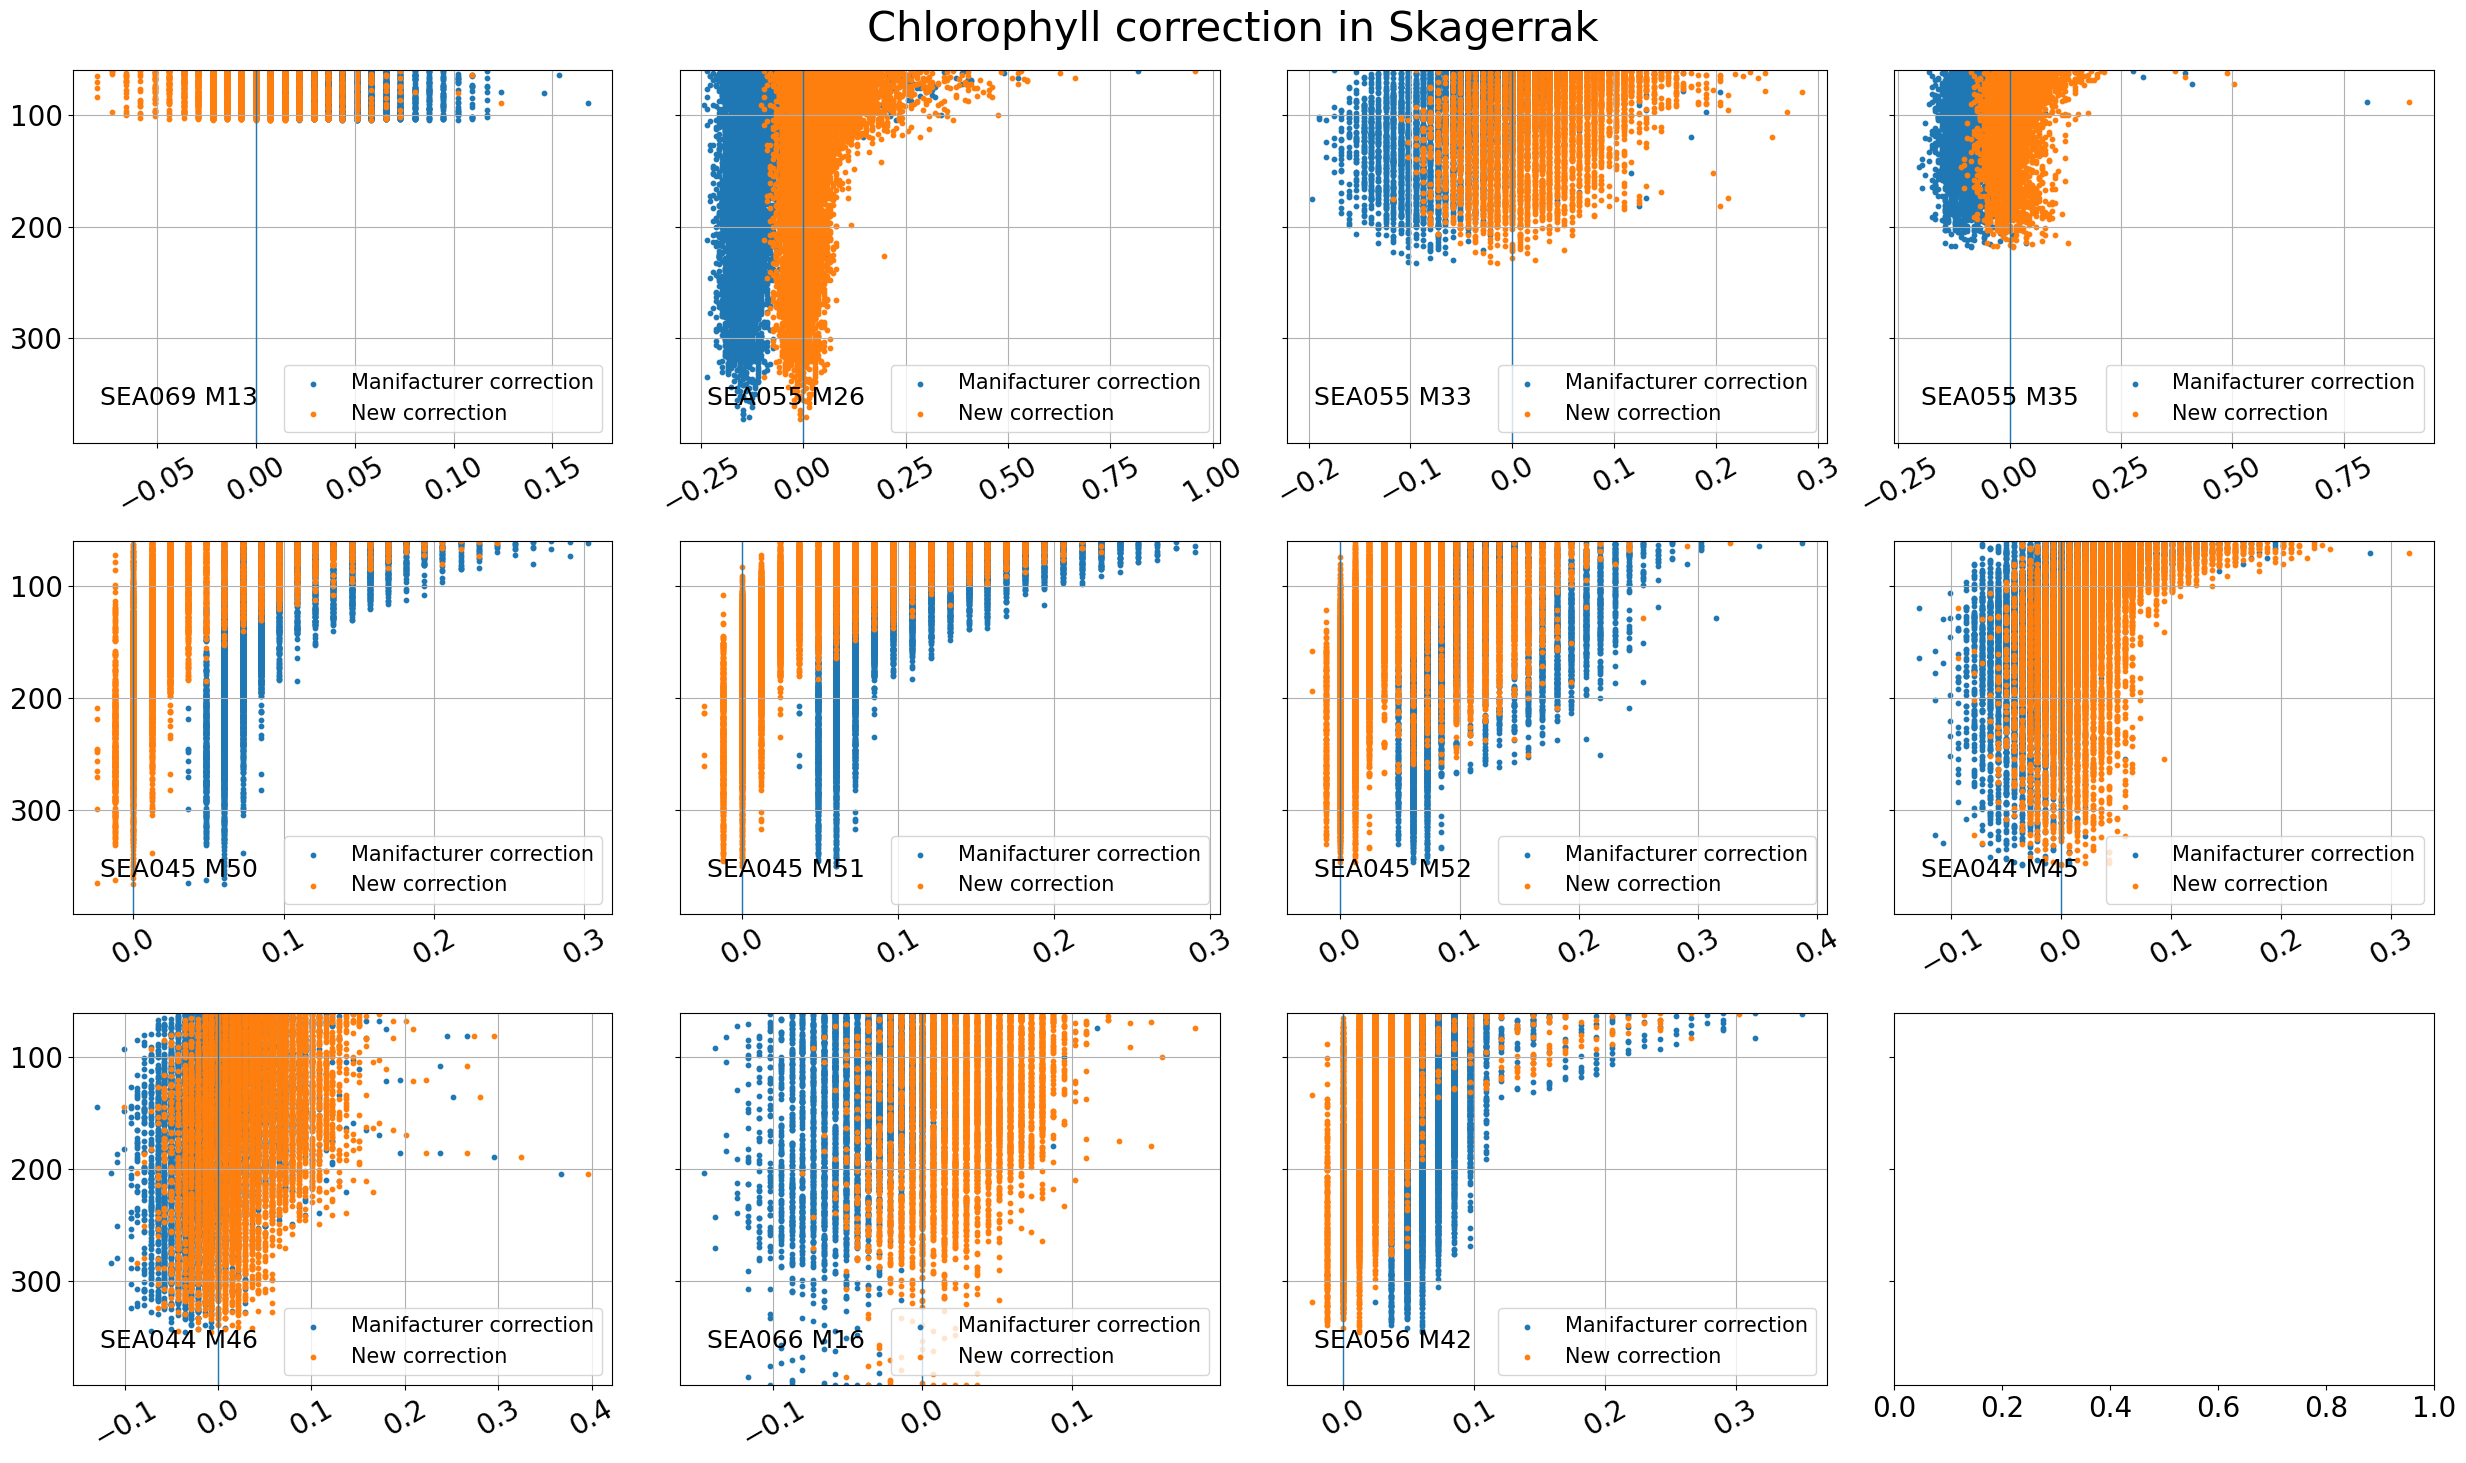

In [64]:
plot_oldNewCorrection(skagerrak_missions,ds_dictS,"Chlorophyll correction in Skagerrak", 0.94,60)

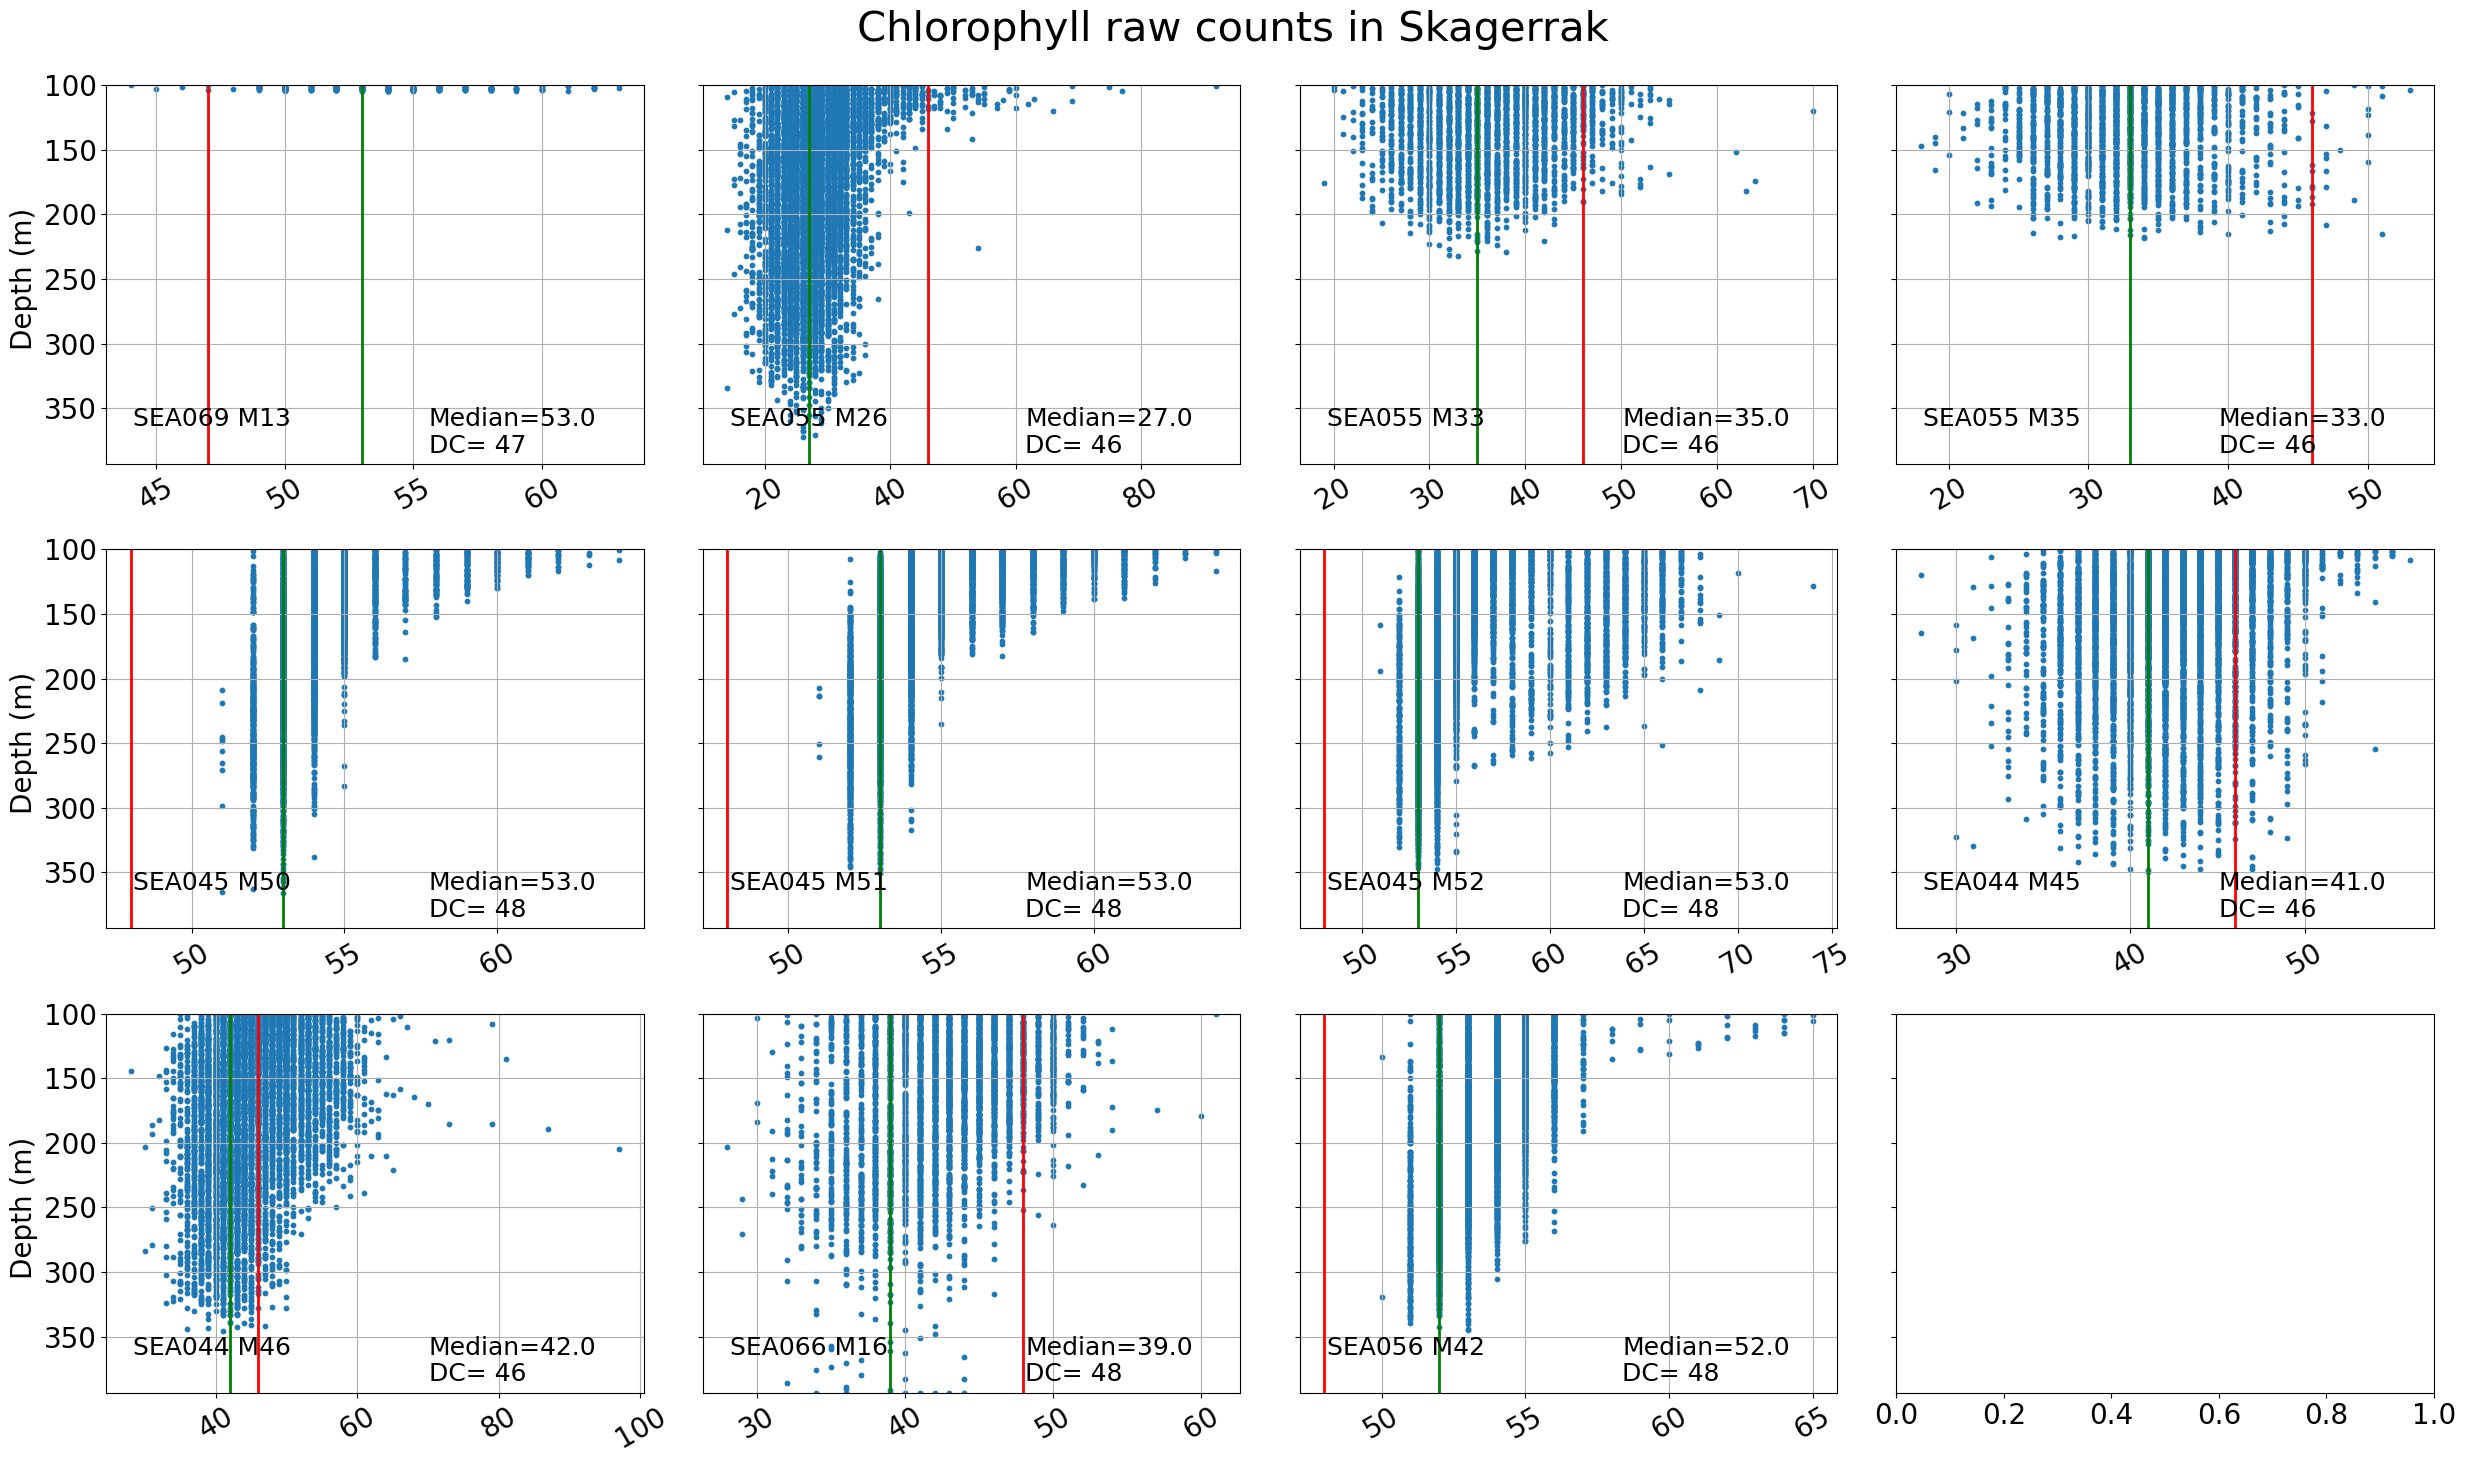

In [63]:
plot_deepCHLcounts(skagerrak_missions,ds_dictS,"Chlorophyll raw counts in Skagerrak", 0.93,100)

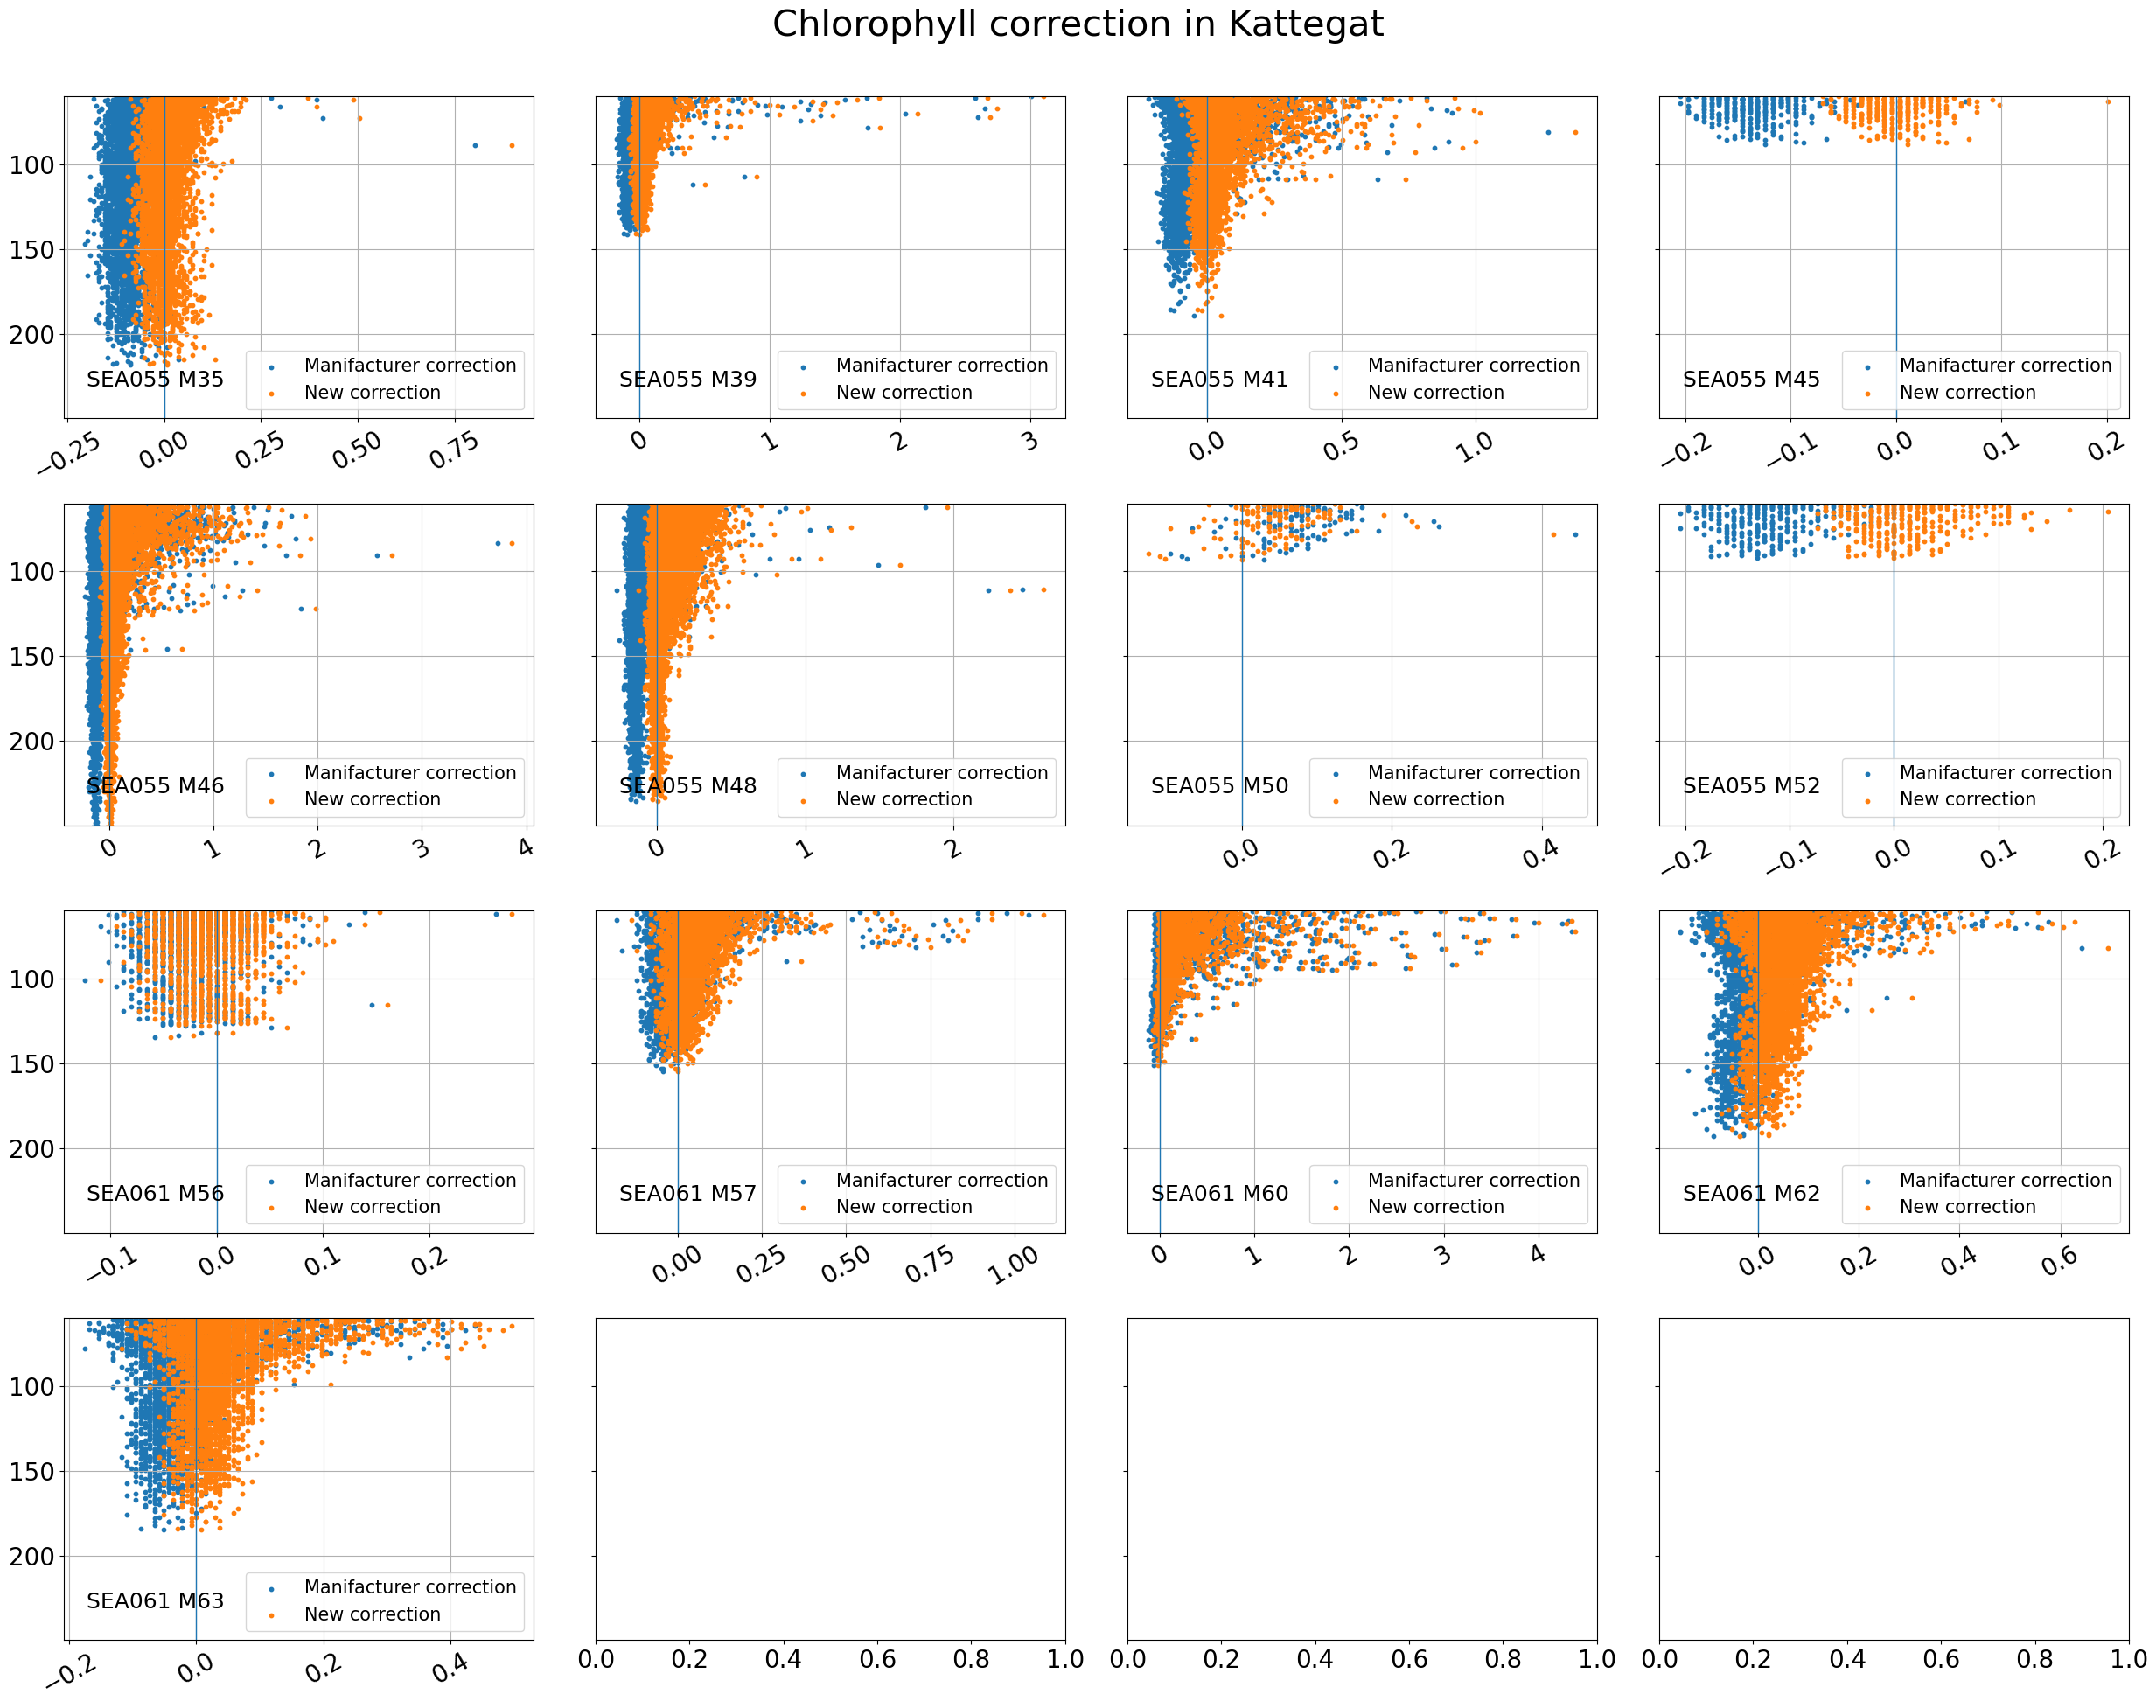

In [45]:
plot_oldNewCorrection(kattegat_missions,ds_dictK,"Chlorophyll correction in Kattegat", 0.93,60)

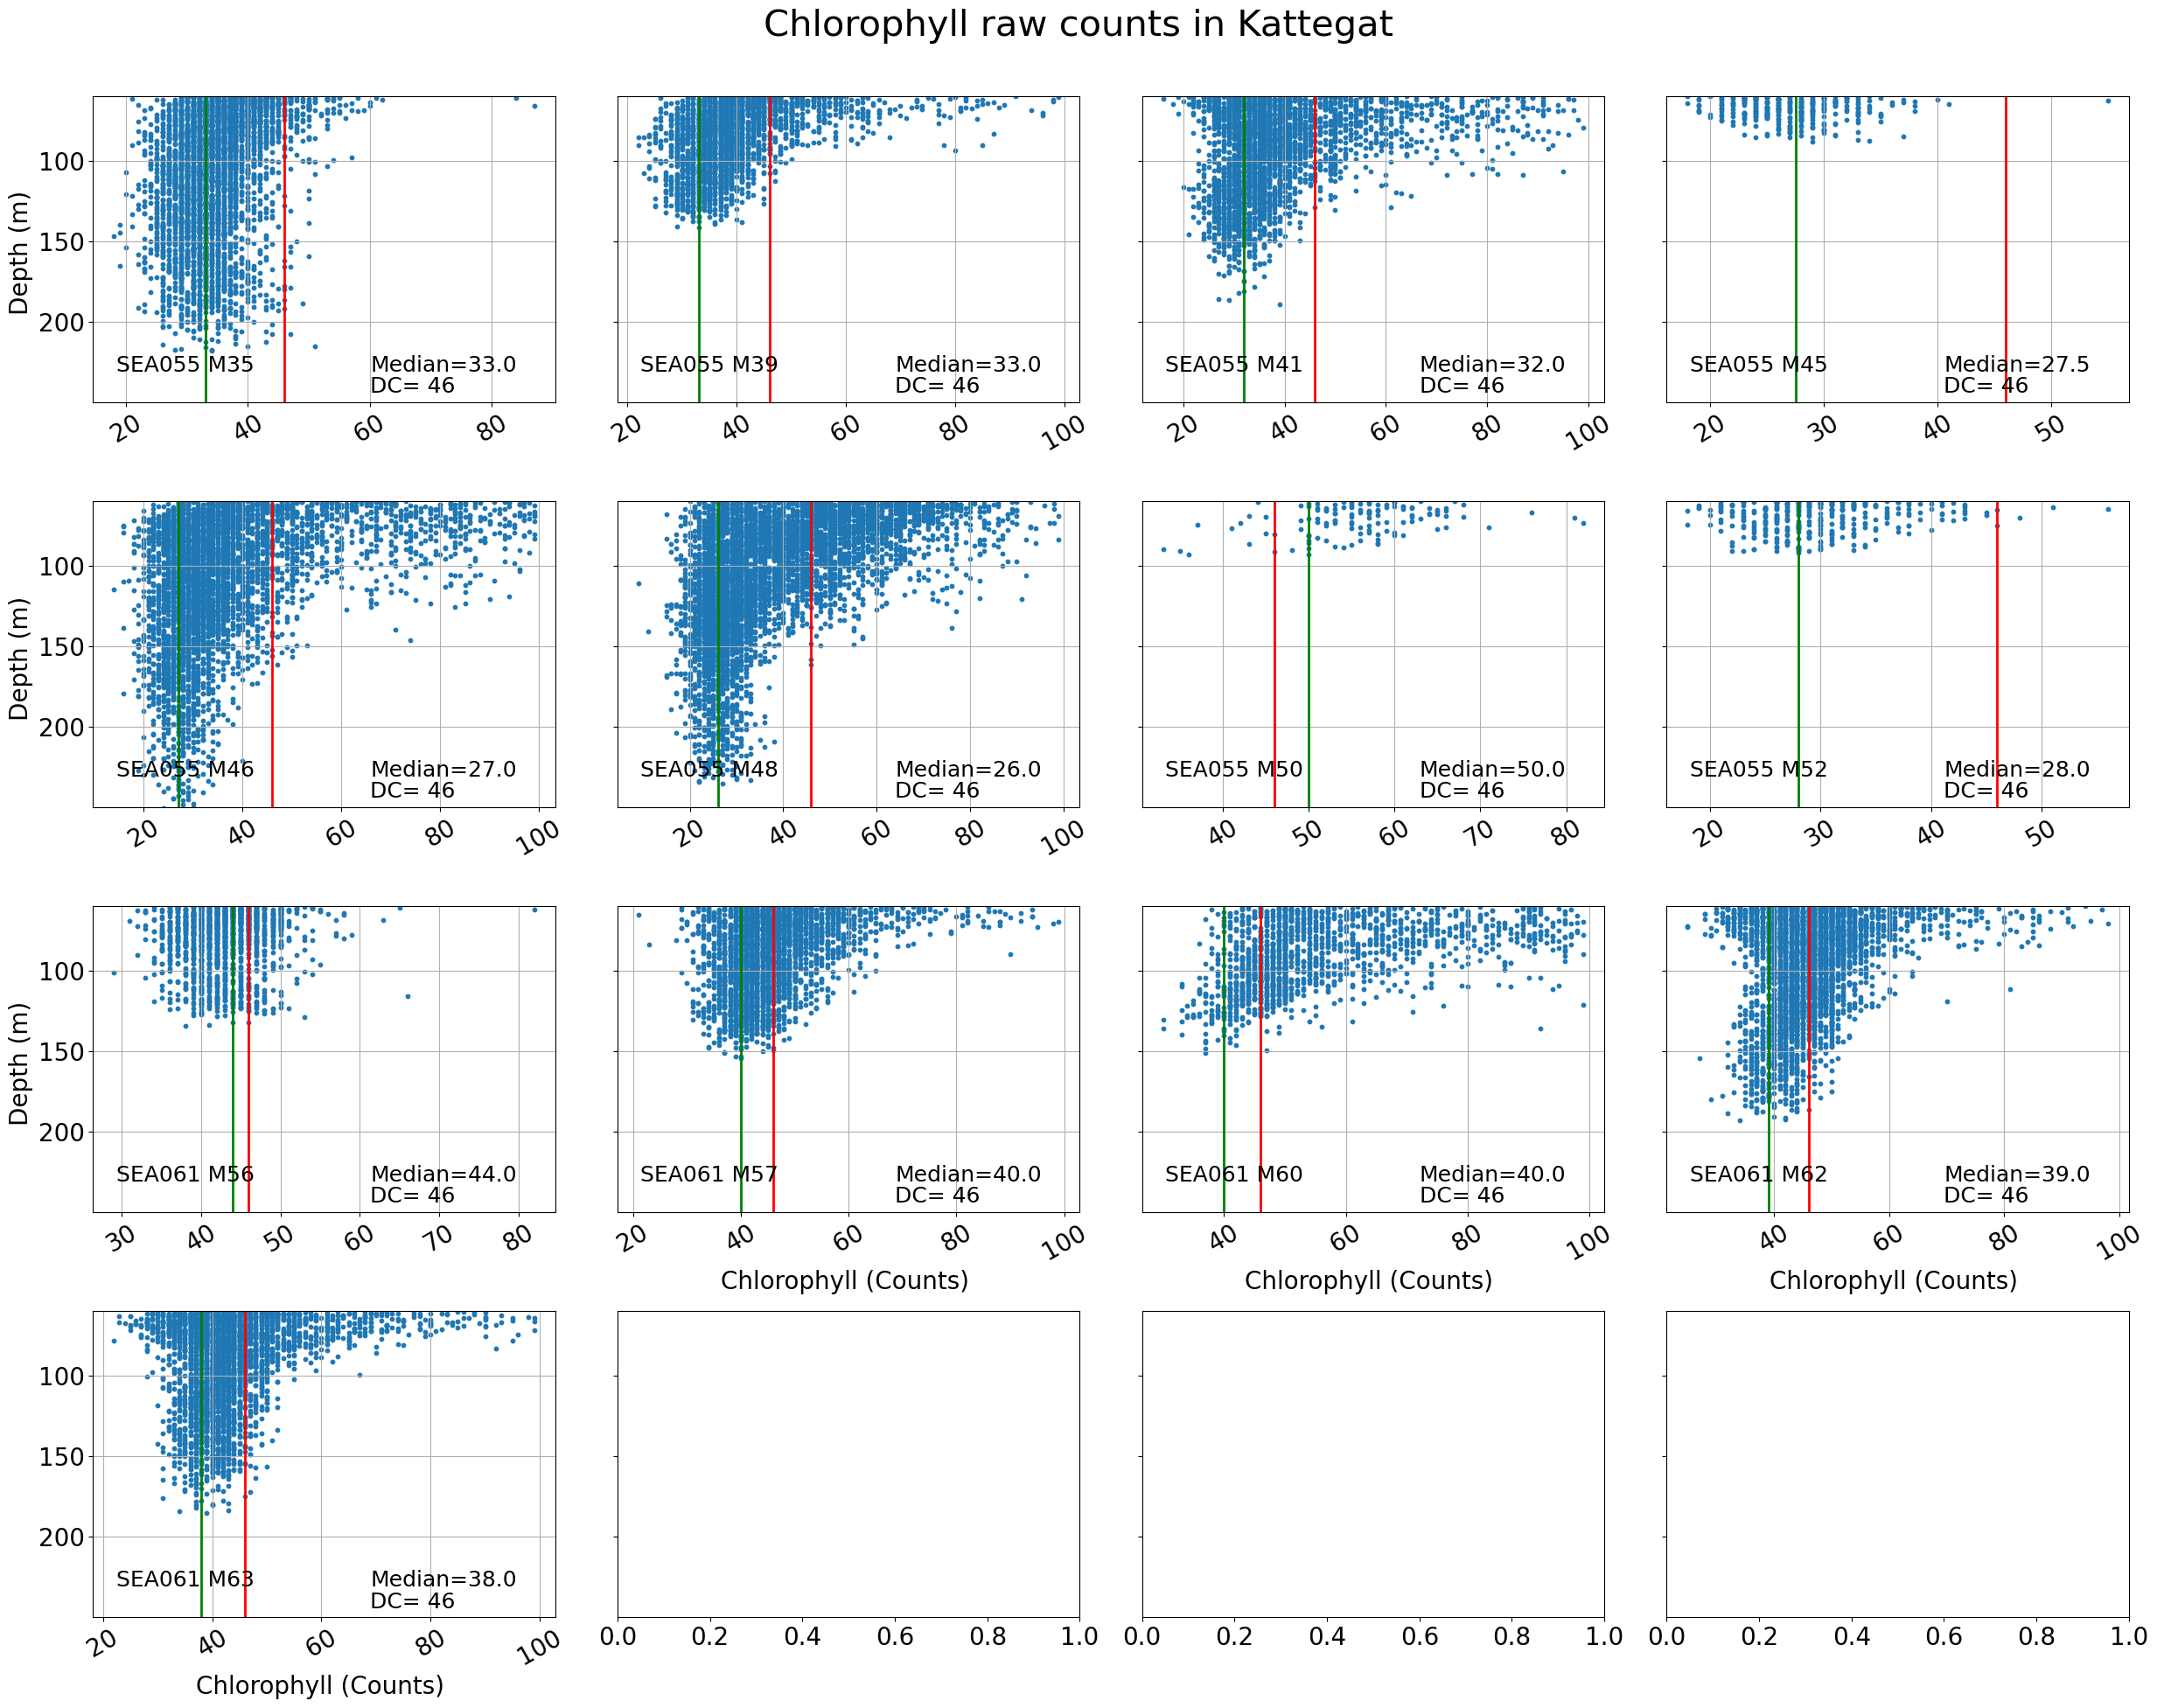

In [57]:
plot_deepCHLcounts(kattegat_missions,ds_dictK,"Chlorophyll raw counts in Kattegat", 0.93,60)

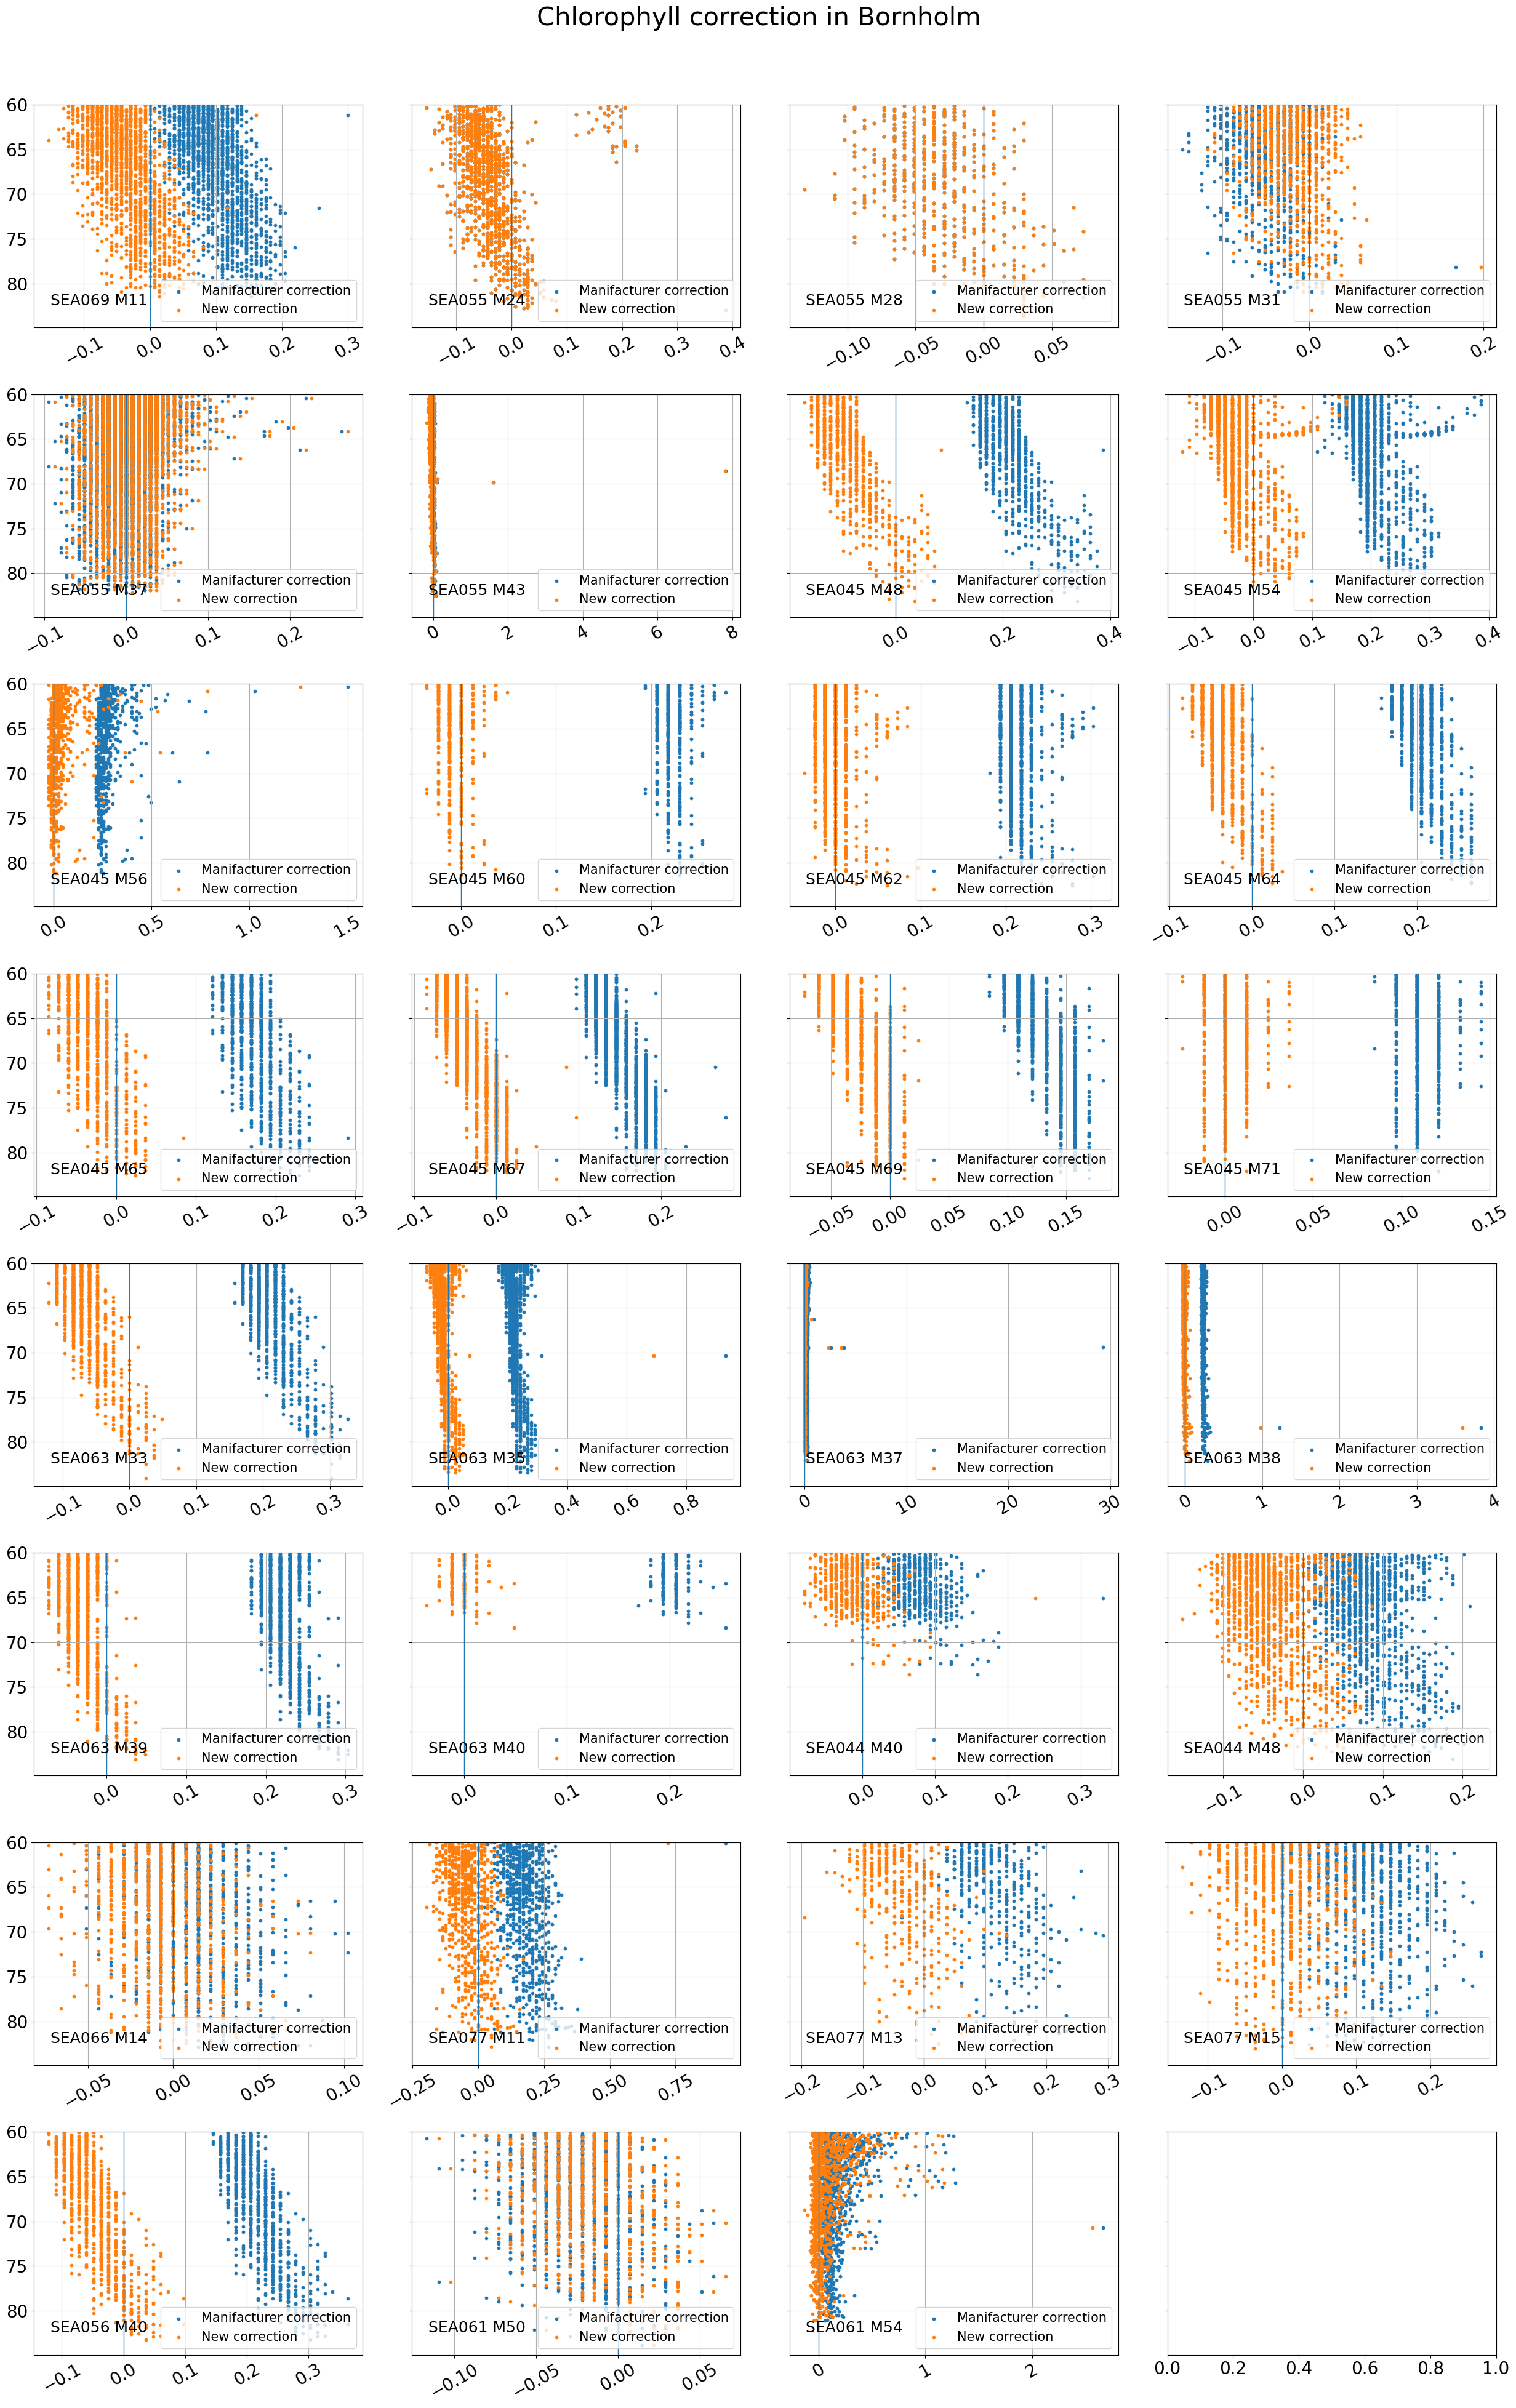

In [66]:
plot_oldNewCorrection(bornholm_missions,ds_dictB,"Chlorophyll correction in Bornholm", 0.94,60)

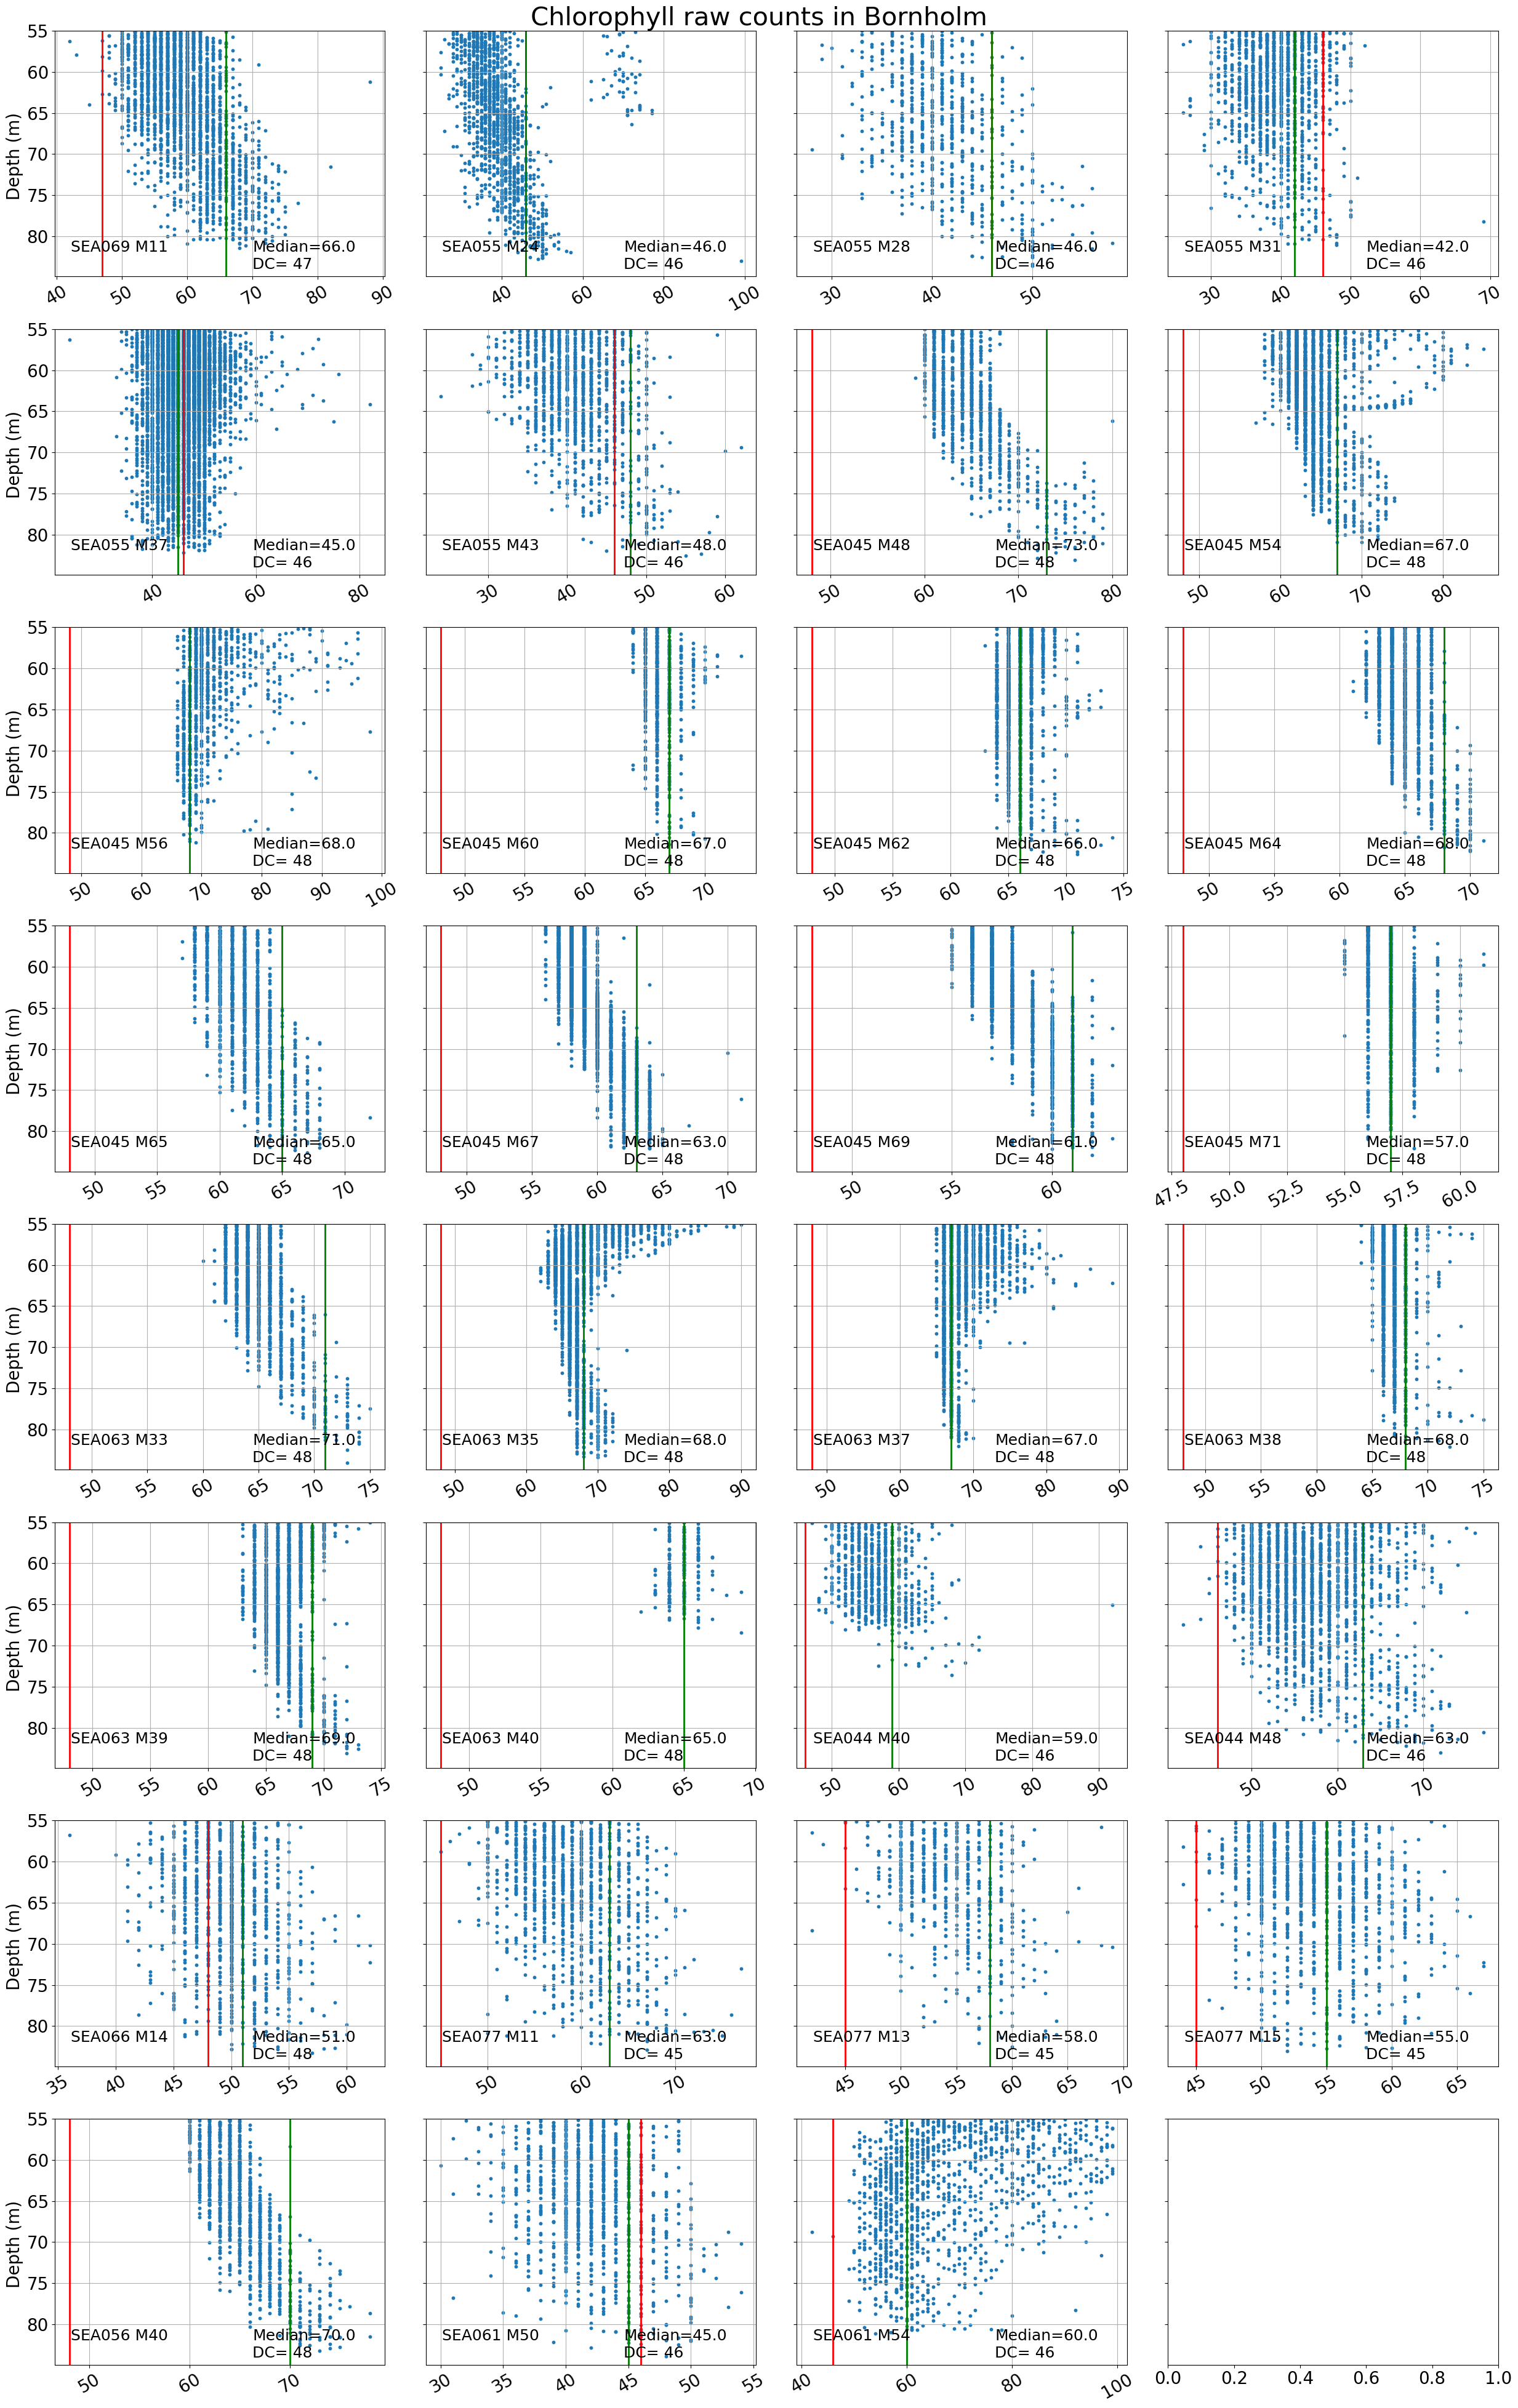

In [47]:
plot_deepCHLcounts(bornholm_missions,ds_dictB,"Chlorophyll raw counts in Bornholm", 0.97,55)

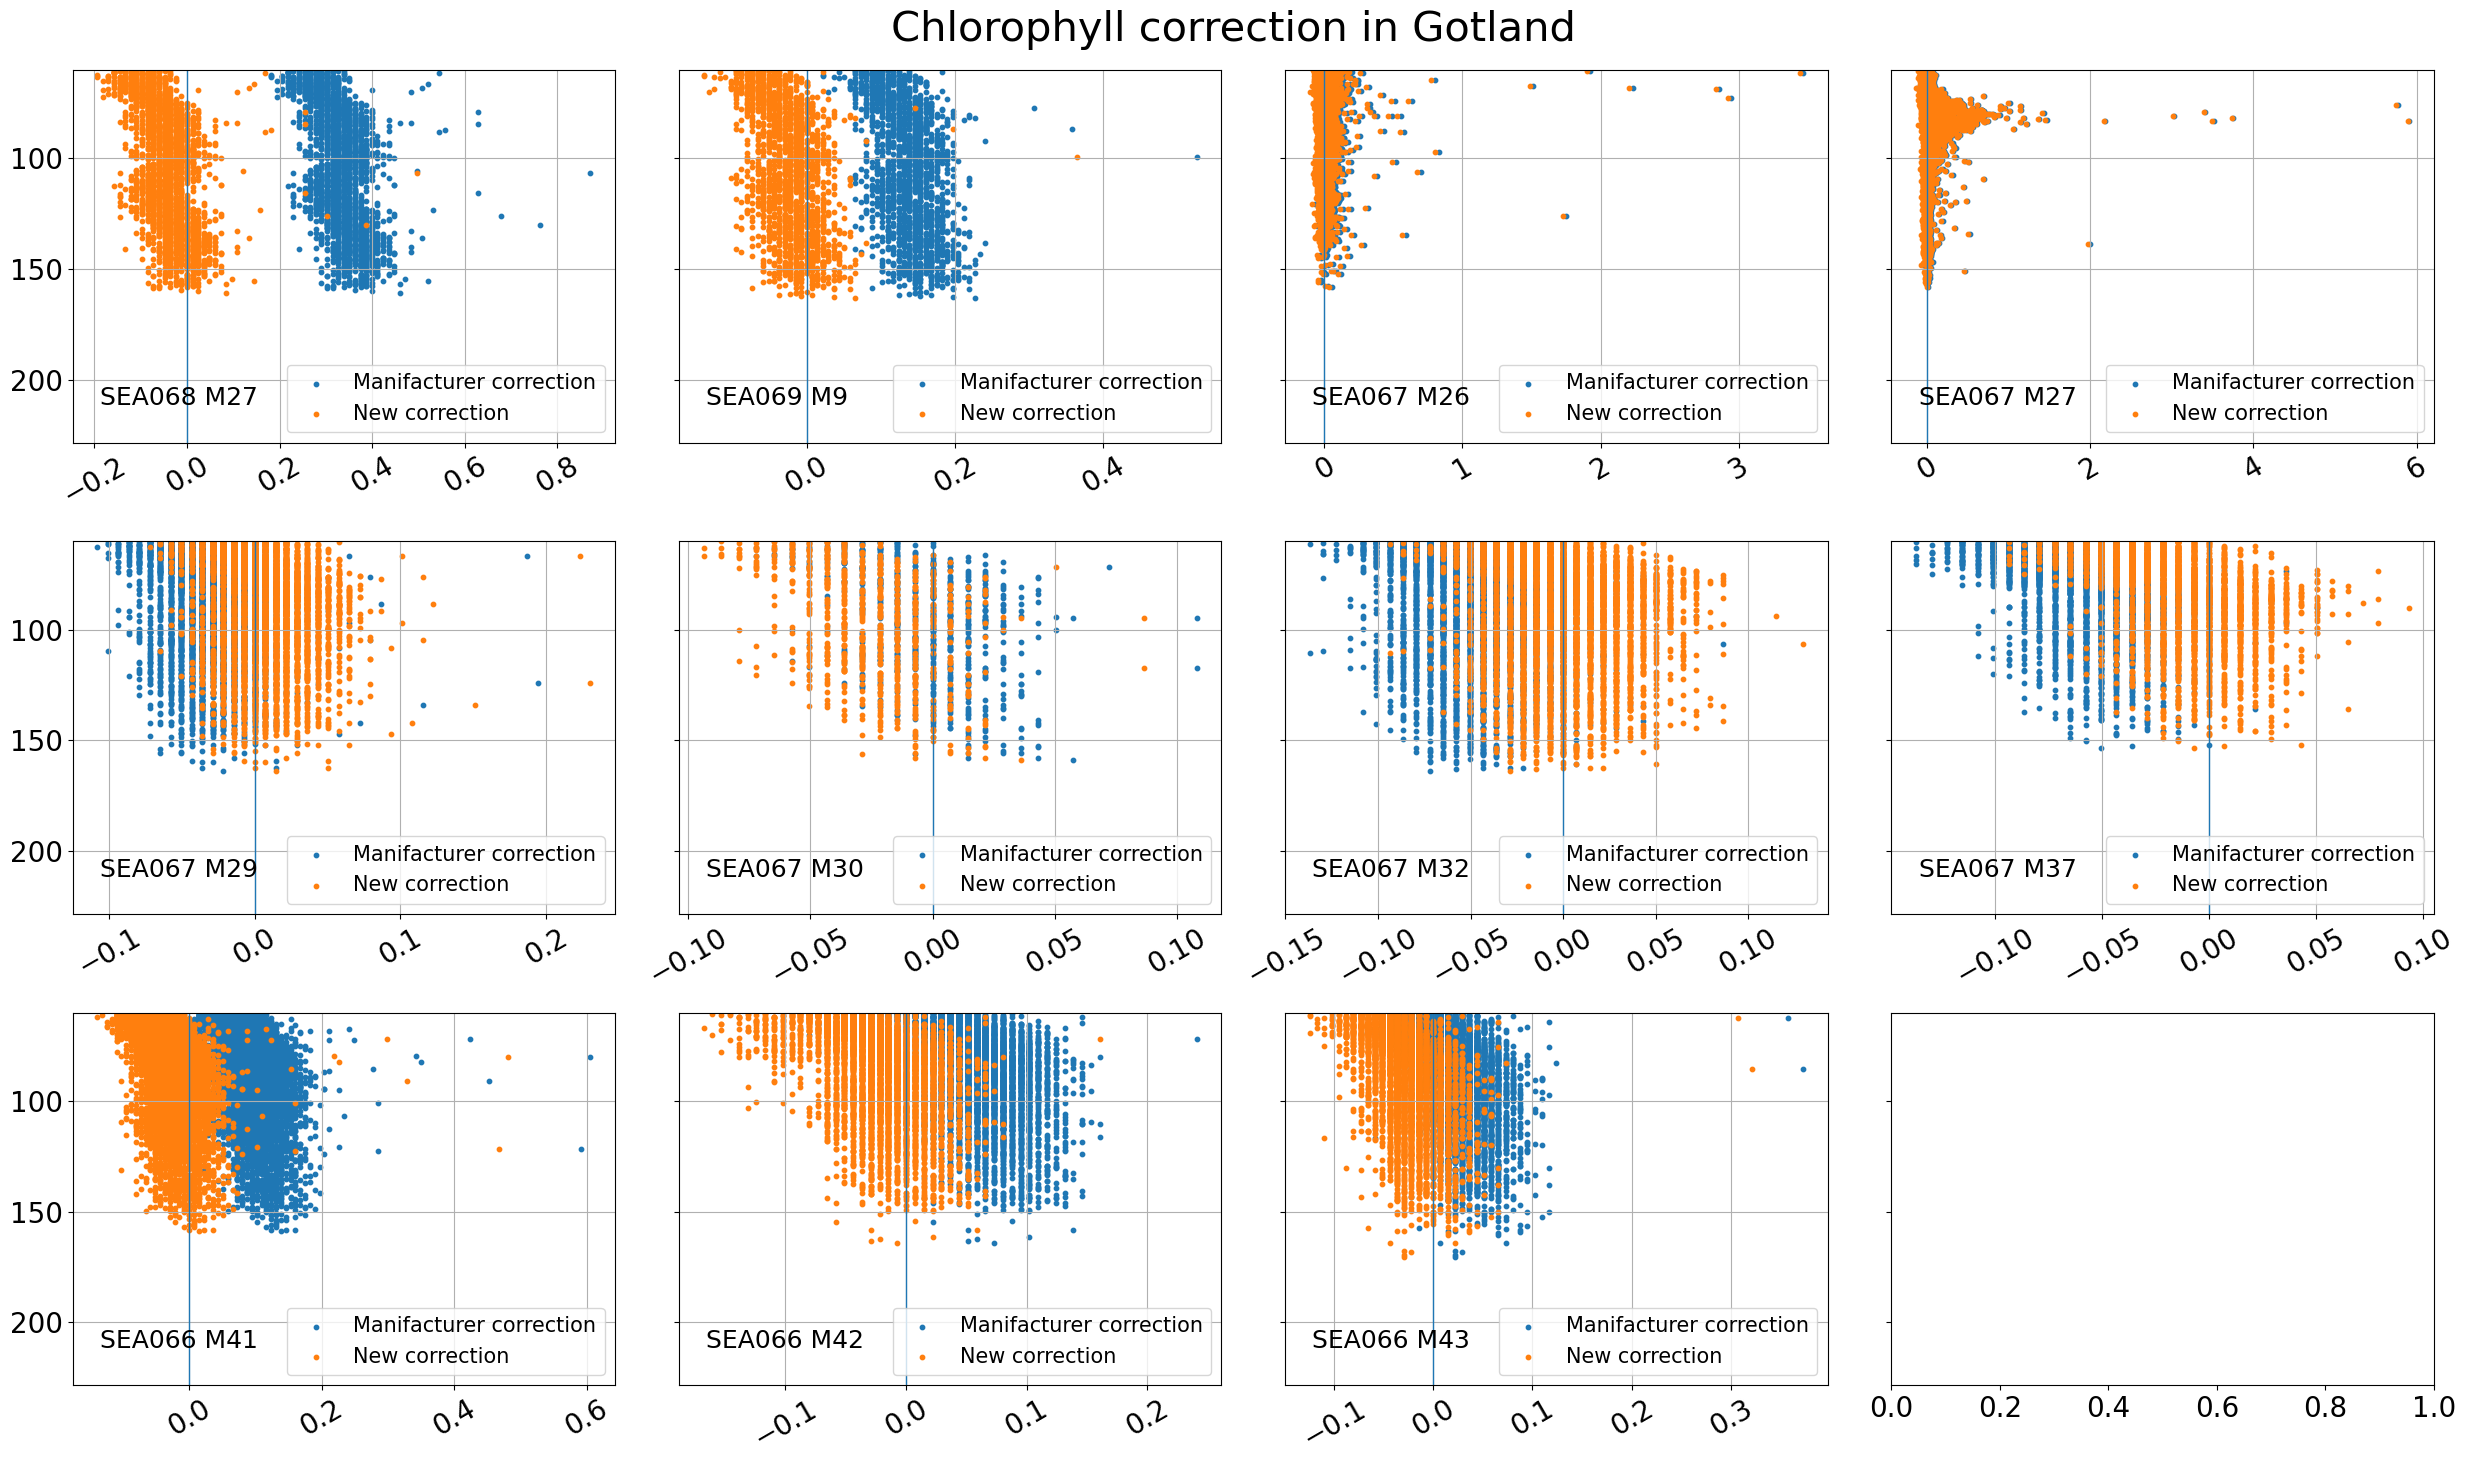

In [65]:
plot_oldNewCorrection(gotland_missions,ds_dictG,"Chlorophyll correction in Gotland", 0.94,60)

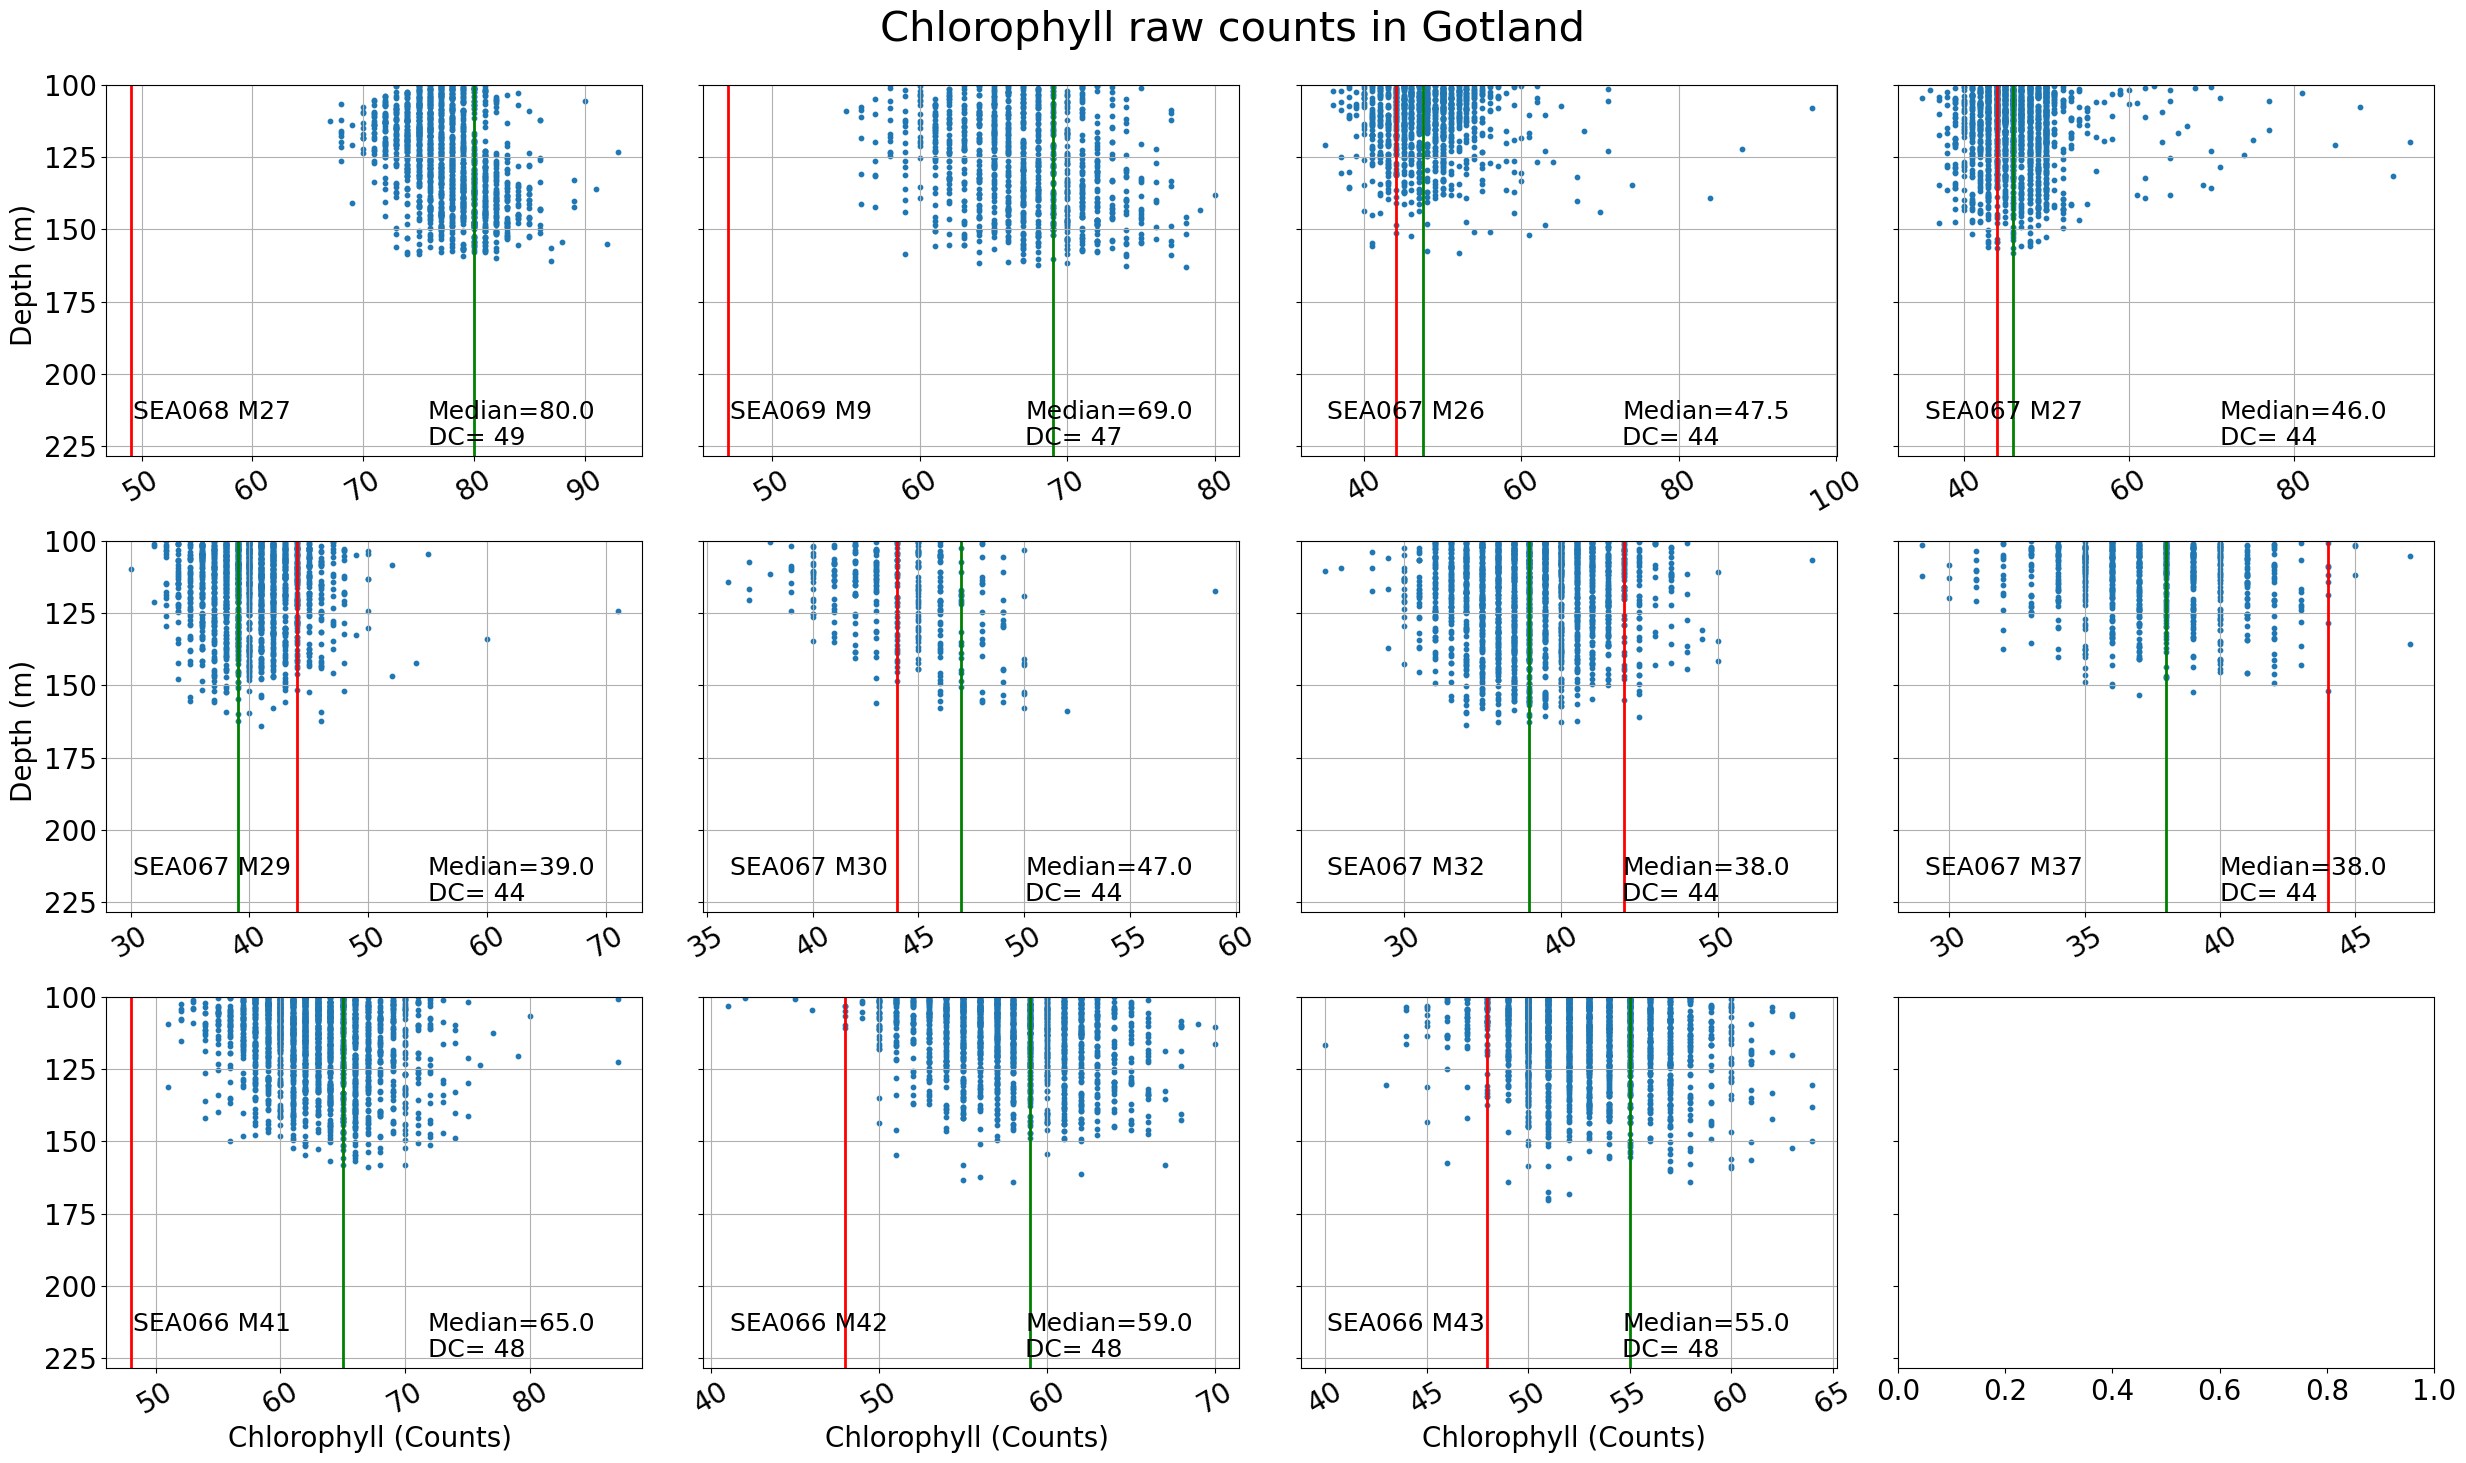

In [56]:
plot_deepCHLcounts(gotland_missions,ds_dictG,"Chlorophyll raw counts in Gotland", 0.93,100)

## Random tests

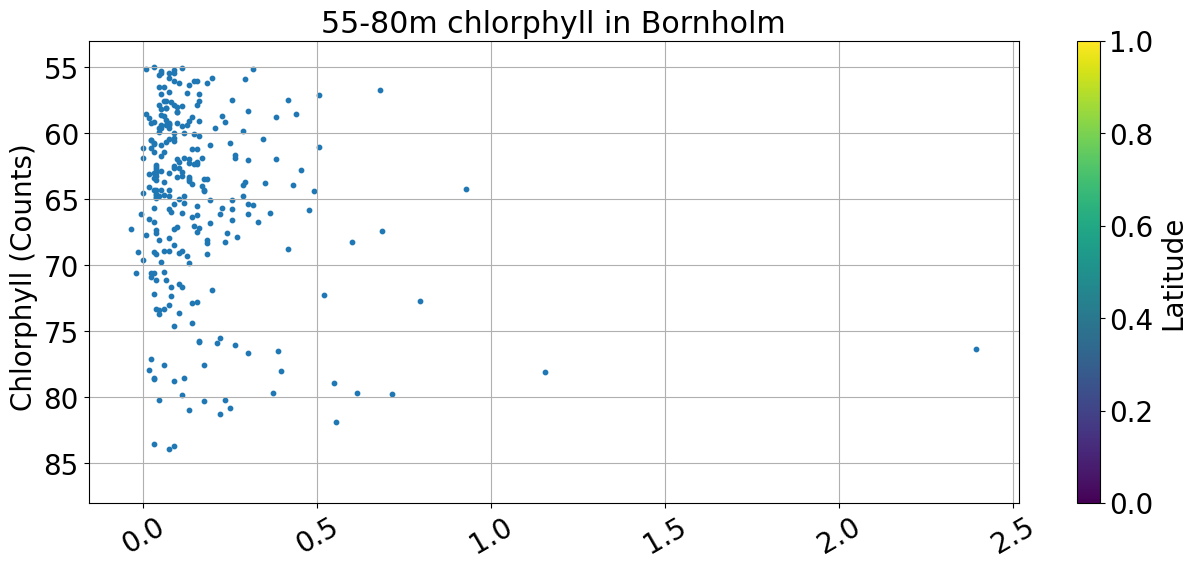

In [119]:
d=ds_dict['nrt_SEA055_M20']
min_depth = 55
fig, ax = plt.subplots(figsize=(15, 6))

pretty_label = f'SEA0{d.attrs["glider_serial"]} M{d.attrs["deployment_id"]}'
c=ax.scatter(d.chlorophyll[d.depth> min_depth],d.depth[d.depth>min_depth],  label=pretty_label, s=10)
#ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"Chlorphyll (Counts) ", title="55-80m chlorophyll in Bornholm")
ax.set_ylim(88,53)

plt.colorbar(c, label='Latitude')

plt.grid()

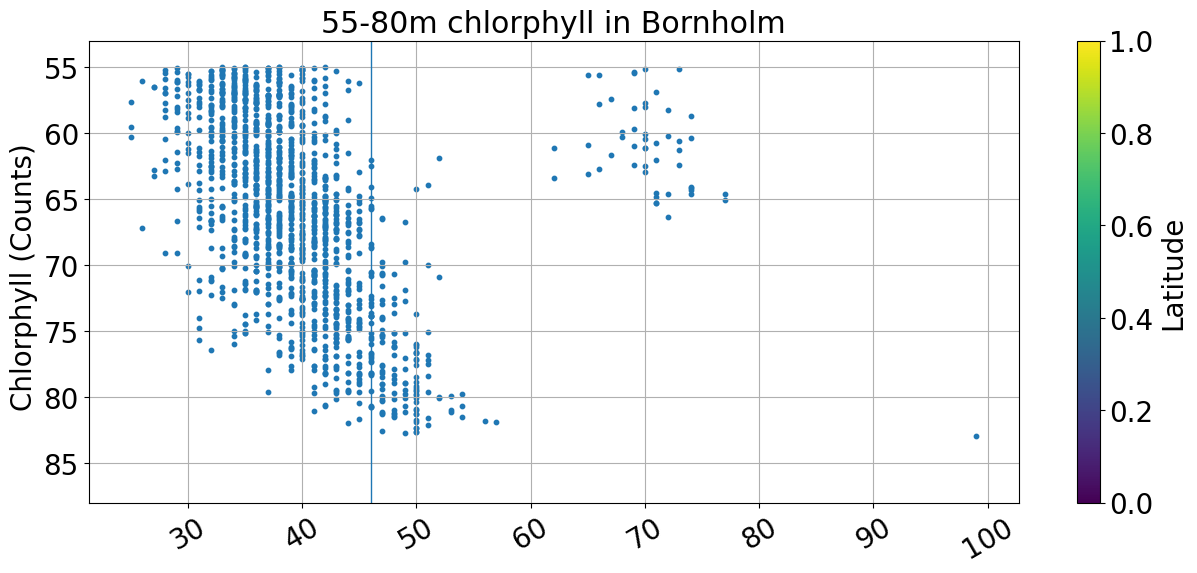

In [69]:
d=ds_dict['nrt_SEA055_M24']
min_depth = 55
fig, ax = plt.subplots(figsize=(15, 6))

pretty_label = f'SEA0{d.attrs["glider_serial"]} M{d.attrs["deployment_id"]}'
c=ax.scatter(d.chlorophyll_raw[d.depth> min_depth],d.depth[d.depth>min_depth],  label=pretty_label, s=10)
#ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"Chlorphyll (Counts) ", title="55-80m chlorphyll in Bornholm")
ax.set_ylim(88,53)
dc=ast.literal_eval(d.optics)['calibration_parameters']['Chl_DarkCounts']
ax.axvline(x=dc)

plt.colorbar(c, label='Latitude')

plt.grid()

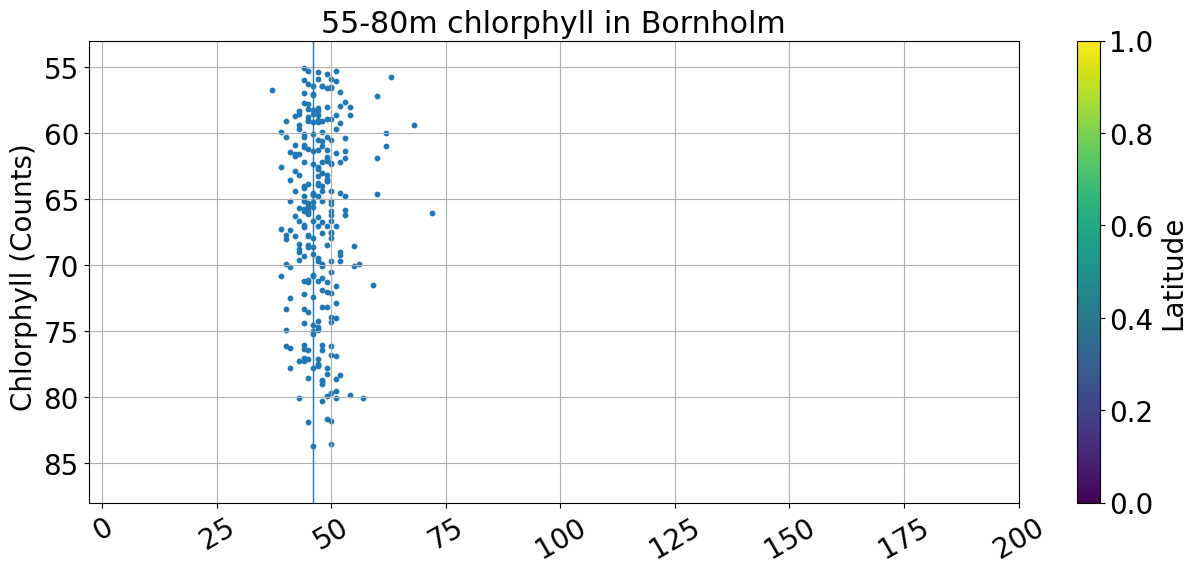

In [46]:
d=ds_dict['nrt_SEA055_M21']
min_depth = 55
fig, ax = plt.subplots(figsize=(15, 6))

pretty_label = f'SEA0{d.attrs["glider_serial"]} M{d.attrs["deployment_id"]}'
c=ax.scatter(d.chlorophyll_raw[d.depth> min_depth],d.depth[d.depth>min_depth],  label=pretty_label, s=10)
#ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"Chlorphyll (Counts) ", title="55-80m chlorphyll in Bornholm")
ax.set_ylim(88,53)
ax.set_xlim(-3,200)
ax.axvline(x=46)
plt.colorbar(c, label='Latitude')

plt.grid()

C:\Users\monfo\anaconda3\envs\environment\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\monfo\anaconda3\envs\environment\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


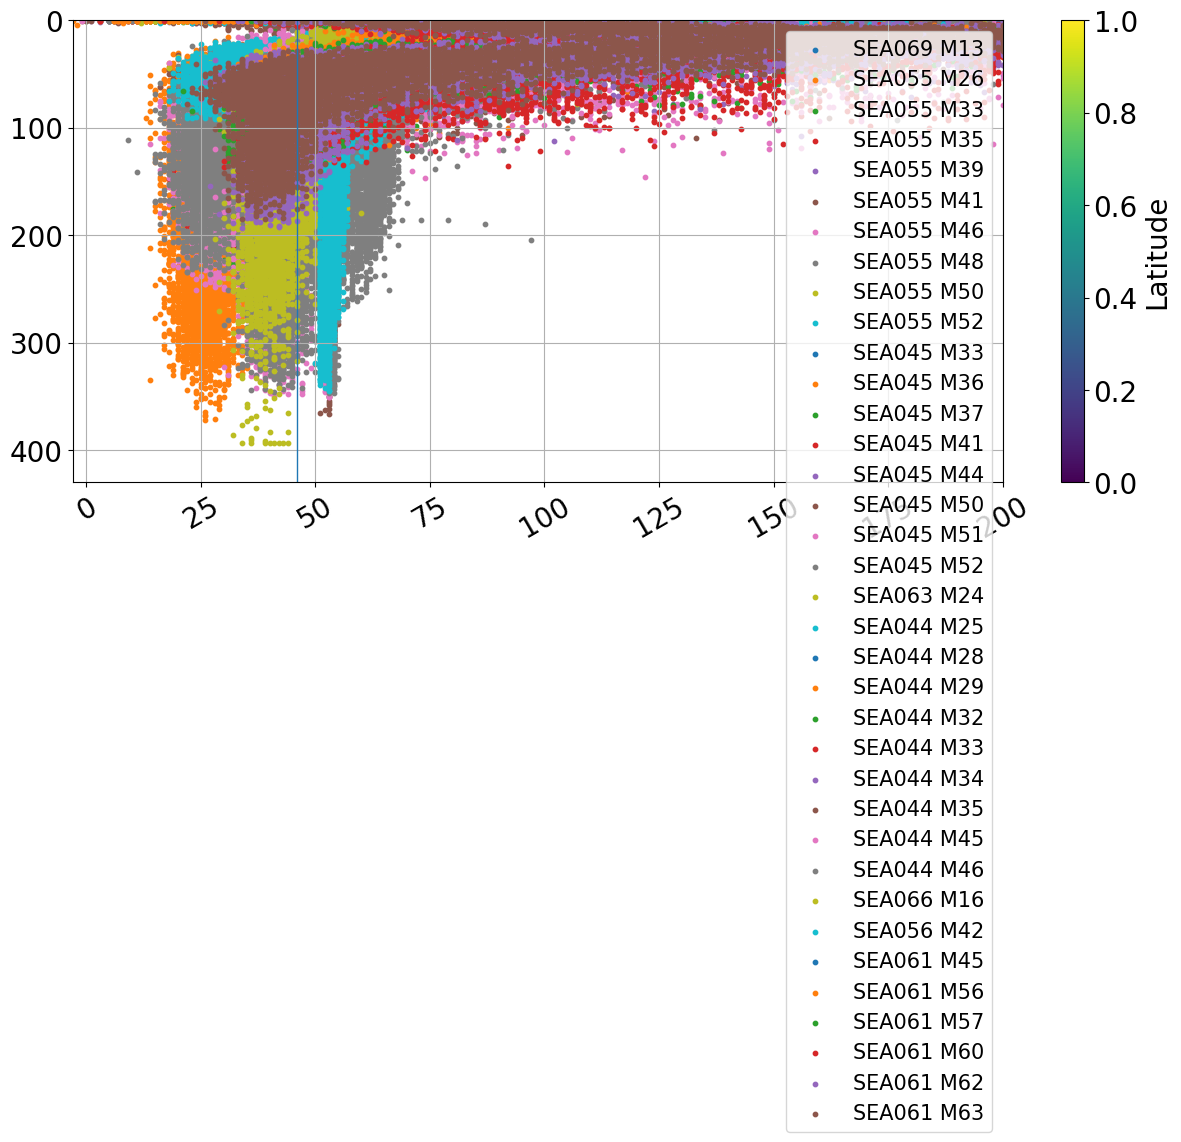

In [101]:
min_depth = 0
fig, ax = plt.subplots(figsize=(15, 6))
for name, ds in ds_dictS.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    c=ax.scatter( ds.chlorophyll_raw[ds.depth> min_depth],ds.depth[ds.depth>min_depth], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.axvline(x=46)
#ax.set(ylabel=f"Chlorphyll (Counts) ", title="55-80m chlorphyll in Bornholm")
ax.set_ylim(430,0)
ax.set_xlim(-3,200)
plt.colorbar(c, label='Latitude')

plt.grid()

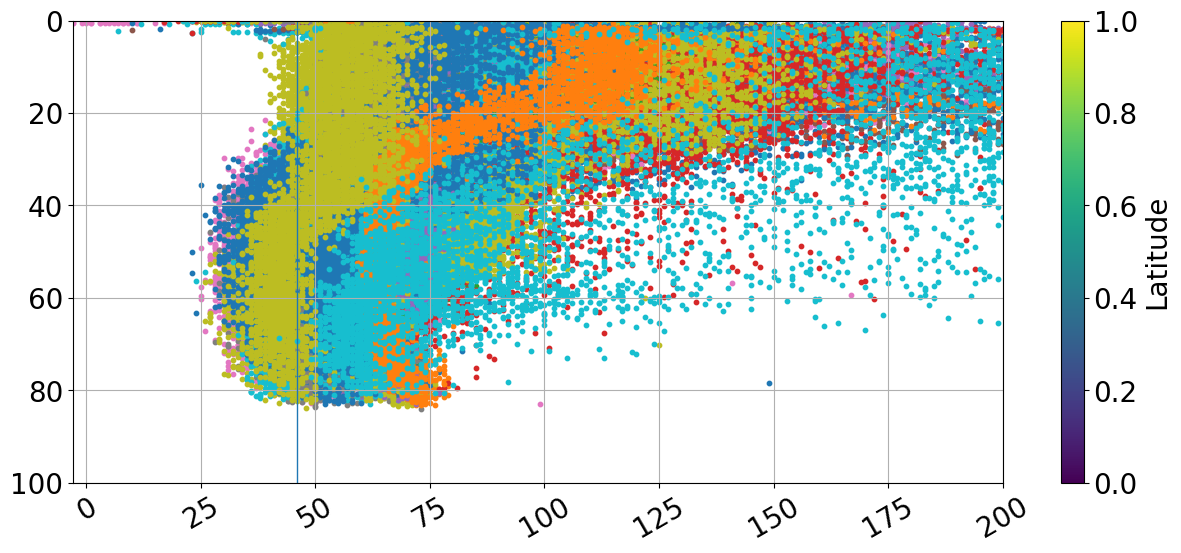

In [100]:
min_depth = 0
fig, ax = plt.subplots(figsize=(15, 6))
for name, ds in ds_dictB.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    c=ax.scatter( ds.chlorophyll_raw[ds.depth> min_depth],ds.depth[ds.depth>min_depth], label=pretty_label, s=10)
#ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.axvline(x=46)
#ax.set(ylabel=f"Chlorphyll (Counts) ", title="55-80m chlorphyll in Bornholm")
ax.set_ylim(100,0)
ax.set_xlim(-3,200)
plt.colorbar(c, label='Latitude')

plt.grid()